<small>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones, FaMAF UNC, 2021.</small>
# Análisis y Visualización de Datos 

Este trabajo pertenece a la mentoría **GAP: Gestión Automática de Pedidos de Combustibles Líquidos basada en telemetría de inventarios**.

Integrantes:
- Bernaschini, María Laura
- Bosch, Daniela
- Rodríguez, Martín

## Introducción

Para alcanzar los objetivos propuestos en el proyecto, será necesario comprender el dataset, tomar sensibilidad y definir criterios del dominio para tomar decisiones sobre los procesos de curación, selección de modelos y realizar ingeniería de features si hiciera falta. En este práctico deberemos descubrir los patrones de manejo de inventarios y consumos por industria y producto. Buscaremos una sugerencia de una solución básica para estimar inventarios de corto plazo.

### Sobre el dataset

El dataset está conformado por el historial de inventarios de tanques en sitios de diferentes empresas. Se trata de información real de centros operativos distribuidos en Argentina y algunos otros países. Los historiales son del primer trimestre de 2021. Los datos provienen de **sensores de nivel magnetostrictivos** colocados en los tanques de los centros operativos. Los datos son almacenados en servidores sin demasiada curación. Pueden contener errores. Puede haber datos faltantes en algunos casos.

La principal información del dataset es el `volumen` medido en los tanques durante el paso del tiempo (`timestamp`). Sin embargo, features como `temperatura`, `codigo`, `producto`, `id_equipo`, `id_tanque`, `capacidad`, `industria`, permiten realizar un tratamiento de los datos para agruparlos y caracterizarlos, lo cual es necesario para comprender el dataset y luego entrenar un modelo de estimación generalista con hiperparámetros o features adicionales.

In [ ]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn
from datetime import datetime, timedelta

seaborn.set_context('talk')
# Set float format
pd.set_option('display.float_format','{:.2f}'.format)

# Set style
seaborn.set_style("darkgrid")
seaborn.set_palette('pastel')
seaborn.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12}) 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Lectura del dataset



Como se trata de un dataset de gran tamaño debemos hacer algunas conversiones antes de leerlo.

In [ ]:
# Funciones auxiliares para la conversión de tipos
def convert2float32(n):
    try:
        return numpy.float32(n)
    except:
        return numpy.nan

def convert2float16(n):
    try:
        return numpy.float16(n)
    except:
        return numpy.nan

def convert2int16(n):
    try:
        return numpy.int16(n)
    except:
        return numpy.nan

def convert2int8(n):
    try:
        return numpy.int8(n)
    except:
        return numpy.nan

Habiendo analizado previamente los datos del csv, se setean tipos y conversiones para levantar el dataset completo.

In [ ]:
dtypes = {
    "id": "category",
    "id_equipo": "category",
    "id_tanque": "category",
    "producto": "category",
    "id_empresa": "category",
    "id_canal": "category",
    "nombre_producto": "category",
    "industria": "category",
    "alarma": "boolean"
}

# Para evitar datos erróneos en el parsing
converters = {
    "id_industria": convert2float16,
    "volumen": convert2float32,
    "vbat1": convert2int16,
    "vbat2": convert2int16,
    "capacidad": convert2float32,
    "fuel_level_dmm": convert2float32,
    "water_level_dmm": convert2float32,
    "water_volume_lts": convert2float32,
    "temp5": convert2float16,
    "temp4": convert2float16,
    "temp3": convert2float16,
    "temp2": convert2float16,
    "temp1": convert2float16,
    "temperatura": convert2float16,
    "coef_var_vol": convert2float16,
    "density": convert2float32
}

In [ ]:
# filename = '/content/drive/MyDrive/Colab Notebooks/DiploDatos/Mentoría/Datasets/dataset100mil.csv'
# filename = '/content/drive/MyDrive/Colab Notebooks/Diplo_Datos/Mentoria_GAP/StorageInventory_2021_Q1.csv'
filename = '/content/drive/MyDrive/Colab Notebooks/DiploDatos/Mentoría/Datasets/StorageInventory_2021_Q1.csv'
raw_df = pd.read_csv(
    filename, 
    converters=converters, 
    dtype=dtypes, 
    parse_dates=["timestamp"],
    index_col=0
)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
raw_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10148505 entries, 0 to 10148504
Data columns (total 28 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                category      
 1   id_equipo         category      
 2   id_tanque         category      
 3   volumen           float64       
 4   temperatura       float64       
 5   codigo            object        
 6   vbat1             int64         
 7   vbat2             int64         
 8   fuel_level_dmm    float64       
 9   water_level_dmm   float64       
 10  water_volume_lts  float64       
 11  producto          category      
 12  temp5             float64       
 13  temp4             float64       
 14  temp3             float64       
 15  temp2             float64       
 16  temp1             float64       
 17  id_empresa        category      
 18  current_firmware  object        
 19  id_canal          category      
 20  id_industria      float64       
 21  indust

In [ ]:
raw_df.head()

,id,id_equipo,id_tanque,volumen,temperatura,codigo,vbat1,vbat2,fuel_level_dmm,water_level_dmm,water_volume_lts,producto,temp5,temp4,temp3,temp2,temp1,id_empresa,current_firmware,id_canal,id_industria,industria,capacidad,alarma,nombre_producto,coef_var_vol,density,timestamp
0,47936,430,964,17143.94,25.00,N1,67,357,9217.00,0.00,0.00,0,25.00,25.59,23.91,22.30,22.09,36,V61005a1b2e477d,4,1.00,Transportation,50191.00,False,Product 1,0.00,nan,2021-01-01 00:00:46
1,1906999,477,1014,16200.70,26.09,N1,67,304,15727.00,0.00,0.00,3,26.09,26.09,26.59,29.09,-56.59,100,V60603bQ74df1d3,4,6.00,Service Station,21259.00,True,Formula Diesel,0.00,nan,2021-01-01 00:00:24
2,1907000,477,1013,11265.10,25.70,N1,66,297,11579.00,0.00,0.00,2,25.70,-56.59,-56.59,-56.59,-56.59,100,V60603bQ74df1d3,4,6.00,Service Station,15032.00,True,VP Diesel,0.00,0.00,2021-01-01 00:00:31
3,1907001,477,1010,865.65,24.80,N1,66,302,1865.00,0.00,0.00,0,24.80,25.91,26.00,26.59,-56.59,100,V60603bQ74df1d3,4,6.00,Service Station,15032.00,True,VP Nafta,0.00,0.00,2021-01-01 00:00:38
4,1907002,477,1011,1929.49,26.00,N1,61,272,3255.00,0.00,0.00,1,26.00,-56.59,-56.59,-56.59,-56.59,100,V60603bQ74df1d3,4,6.00,Service Station,15032.00,True,Super,0.00,nan,2021-01-01 00:00:41


## Exploración y limpieza de los datos

Antes de analizar cada una de las features de dataset, debemos convertir algunos tipos de datos, conocer cada uno de los features y realizar la limpieza según distintos criterios.

### Tipo de datos de columnas

A fines de realizar correctamente el análisis y de optimizar el tamaño de nuestro dataframe realizamos algunas conversiones de tipos de acuerdo a los valores observados previamente. Luego, obtenemos una copia del mismo para no modificar la información del dataset original.

In [ ]:
raw_df['volumen'] = raw_df['volumen'].astype(numpy.float32)
raw_df['temperatura'] = raw_df['temperatura'].astype(numpy.float16)
raw_df['temp5'] = raw_df['temp5'].astype(numpy.float16)
raw_df['temp4'] = raw_df['temp4'].astype(numpy.float16)
raw_df['temp3'] = raw_df['temp3'].astype(numpy.float16)
raw_df['temp2'] = raw_df['temp2'].astype(numpy.float16)
raw_df['temp1'] = raw_df['temp1'].astype(numpy.float16)
raw_df['fuel_level_dmm'] = raw_df['fuel_level_dmm'].astype(numpy.float32)
raw_df['water_level_dmm'] = raw_df['water_level_dmm'].astype(numpy.float32)
raw_df['water_volume_lts'] = raw_df['water_volume_lts'].astype(numpy.float32)
raw_df['capacidad'] = raw_df['capacidad'].astype(numpy.float32)
raw_df['coef_var_vol'] = raw_df['coef_var_vol'].astype(numpy.float16)
raw_df['density'] = raw_df['density'].astype(numpy.float16)
raw_df['vbat1'] = raw_df['vbat1'].astype(numpy.int16)
raw_df['vbat2'] = raw_df['vbat2'].astype(numpy.int16)
raw_df['id_industria'] = raw_df['id_industria'].astype("category")
raw_df['codigo'] = raw_df['codigo'].astype("str")

In [ ]:
raw_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10148505 entries, 0 to 10148504
Data columns (total 28 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                category      
 1   id_equipo         category      
 2   id_tanque         category      
 3   volumen           float32       
 4   temperatura       float16       
 5   codigo            object        
 6   vbat1             int16         
 7   vbat2             int16         
 8   fuel_level_dmm    float32       
 9   water_level_dmm   float32       
 10  water_volume_lts  float32       
 11  producto          category      
 12  temp5             float16       
 13  temp4             float16       
 14  temp3             float16       
 15  temp2             float16       
 16  temp1             float16       
 17  id_empresa        category      
 18  current_firmware  object        
 19  id_canal          category      
 20  id_industria      category      
 21  indust

In [ ]:
# Trabajamos sobre una copia y no sobre el original
df = raw_df.copy()
len(df)

10148505

In [ ]:
# Si se llena la memoria, ejecutar
# del raw_df

### Valores faltantes

Para esto observaremos las columnas de interés `volumen`, `codigo` y `temperatura`. Vemos además, si se observan intersecciones entre estos conjuntos.

En la intersección que se muestra a continuación, se verifica que cuando no tenemos datos de temperatura tampoco lo tenemos en código, dando a entender que la sonda no está funcionando. Son 1117 muestras que no servirían para nuestro análisis. Además se puede verificar también que no existen datos de fuel_level en estos casos. La línea de código a continuación arroja 0 líneas, confirmando lo anterior. 

In [ ]:
# Análisis de intersección nan entre variables
df[df['temperatura'].isna() & df['codigo'].isna() & ~df['fuel_level_dmm'].isna()]

,id,id_equipo,id_tanque,volumen,temperatura,codigo,vbat1,vbat2,fuel_level_dmm,water_level_dmm,water_volume_lts,producto,temp5,temp4,temp3,temp2,temp1,id_empresa,current_firmware,id_canal,id_industria,industria,capacidad,alarma,nombre_producto,coef_var_vol,density,timestamp


Eliminamos los valores nulos que se observan en nuestra variable de interés `volumen`, ya que no nos sirven para el análisis de inventarios y el cálculo de consumos.

También decidimos eliminar aquellas `temperaturas` que tengan valores nulos, ya que el volumen se ve afectado por la misma (relación que se verá más adelante).

Por último, no tuvimos en cuenta los valores nulos de `codigo` porque inferimos que el sensor no está funcionando y esto coincide con la existencia de valures nulos de temperatura y de nivel de combustible.

In [ ]:
nan = numpy.nan

# Volúmenes nulos
df = df.query("volumen != @nan")

# Temperaturas nulas
df = df.query("temperatura != @nan")

# Códigos nulos
df = df[~df['codigo'].isna()]

len(df)

10148505

### Eliminación de outliers

#### Filtrado de valores erróneos
A partir de la exploración de los datos definimos algunos criterios para el filtrado de nuestra base de datos. Por un lado, pudimos observar que la variable `volumen` posee valores mínimos negativos y que su máximo valor sobrepasa el valor máximo de la capacidad de los tanques, por lo que difinimos la primera y segunda condición de filtrado (`cond_1` y `cond_2`) y nos quedamos con valores de volúmenes mayores o iguales a cero y menores a la capacidad máxima. Por otro lado, vimos que cuando la carga de alguna de las dos baterías es cero el nivel de combustible también es cero o produce valores nulos (nan) por lo que no se estaría estimando correctamente el valor de volumen, definiendo de esta manera las condidiones 3 y 4 (`cond_3` y `cond_4`). Por último, se definió una no condición en donde se excluyen los valores de volumen cero donde el nivel de combustible es mayor a cero, ya que implicaría un error en la conversión de esta variable a volumen (`~cond_5`).

In [ ]:
# Volúmenes negativos
cond_1 = df["volumen"] >= 0

# Volúmenes mayores a la capacidad del tanque
cond_2 = df["volumen"] < df["capacidad"].max()

# Voltaje del pulso de eco 0
cond_3 = df["vbat1"] != 0

# Batería con voltaje 0
cond_4 = df["vbat2"] != 0

# Eliminar valores de volumen cero donde el nivel de combustible es mayor a cero 
cond_5 = (df.volumen == 0) & (df.fuel_level_dmm > 0)

In [ ]:
df = df[cond_1 & cond_2 & cond_3 & cond_4 & ~cond_5]
len(df)

10131992

#### Filtrado de registros con códigos de error

Quitamos aquellos registros que contengan códigos de error. Para esto, separamos la columna `codigo` en dos campos, ya que la misma contiene además información de la cantidad de ecos.

Se deja la [documentación](https://drive.google.com/file/d/1IURbnJ3305CLaJSrvjP2E7_ab9mfdg6r/view) sobre los significados de estos códigos.

In [ ]:
df['codigo'].unique()

array(['N1', 'N2', 'F1', 'N0', 'V1', 'F0', 'm0', 'M1', 'F2', 'L1', 'V0',
       'I1', 'I2', 'V2', 'U2', 'U1', 'L2', 'P1', 'I0', 'T1', 'T0', 'P2',
       'M2', 'L0', 'L3', 'L4', 'V6', 'N4', 'V5', 'N3', 'V3', 'V4', 'm1',
       'U5', 'L6', 'L5', 'L7', 'L8', 'N8', 'L9', 'V8', 'V9', 'V7', 'N5',
       'N7', 'U8', 'N9', 'N6', 'U3', 'U7', 'U6', 'U9', 'U0', '01', 'U4',
       'M0', 'P0'], dtype=object)

In [ ]:
# Separamos el código en dos datos
df['c'] = df['codigo'].apply(lambda x: str(x)[0])
df['echoes'] = pd.to_numeric(df['codigo'].apply(lambda x: str(x)[1]), errors='coerce')

Veamos si quitando los valores con códigos de error obtenemos los mismos resultados que mantener los valores con códigos correctos.

In [ ]:
ok_codes = ['N', 'L', 'V', 'U', 'P', 'T', 'A', 'I', '0']
error_codes = ['m', 'M', 'F']

In [ ]:
# Obtenemos el mismo resultado?
print("Manteniendo los valores correctos:", len(df.query("c not in @ok_codes")))
print("Quitando los valores de error:", len(df.query("c in @error_codes")))

Manteniendo los valores correctos: 1916487
Quitando los valores de error: 1916487


Obtenemos los mismo resultado, elegimos uno de ellos.

In [ ]:
df = df.query("c in @ok_codes")
len(df)

8215505

#### Filtrado de registros con ecos cero y ecos mayores a dos

La cantidad de ecos corresponde a la cantidad de señales recibidas en el transmisor de la sonda.

Si el valor es cero, puede haber ocurrido dos cosas:
- Son sondas de presión, es decir, este tipo de sondas funcionan de manera distinta y la cantidad de ecos no corresponde (ya que no los tiene). Esta tecnología no es tan precisa y se encuentra obsoleta.
- Los datos enviados son erróneos.

Decidimos filtrar estos valores.

In [ ]:
df = df.query("echoes != 0")
len(df)

8154656

Los ecos mayores a dos son erróneos, ya que actualmente la cantidad de mediciones que se realizan son una o dos. Si reporta dos ecos, la sonda, además de medir el líquido principal (generalmente combustible), mide agua.

In [ ]:
df = df.query("echoes <= 2")
len(df)

8152812

#### Filtrado por pérdida de ecos en un mismo tanque
Cuando se pierden señales de eco en sondas que sólo miden un líquido, el código mostrará valores ceros durante esas pérdidas. Pero, ¿qué sucede si la sonda mide dos líquidos y pierde una de las señales? La sonda reportará un valor normal (uno), pero que resulta incorrecto para esta sonda.

No podemos solamente limitarnos a filtrar aquellos con ecos cero, debemos además quitar aquellos que debían ser dos y fue sólo una. Este análisis debe hacerse por tanque.


In [ ]:
# Guardamos la cantidad de ecos/mediciones que tiene ese tanque.
df['max_echoes'] = df.groupby('id_tanque')['echoes'].transform('max')

In [ ]:
df = df.query("echoes == max_echoes")
len(df)

7708744

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


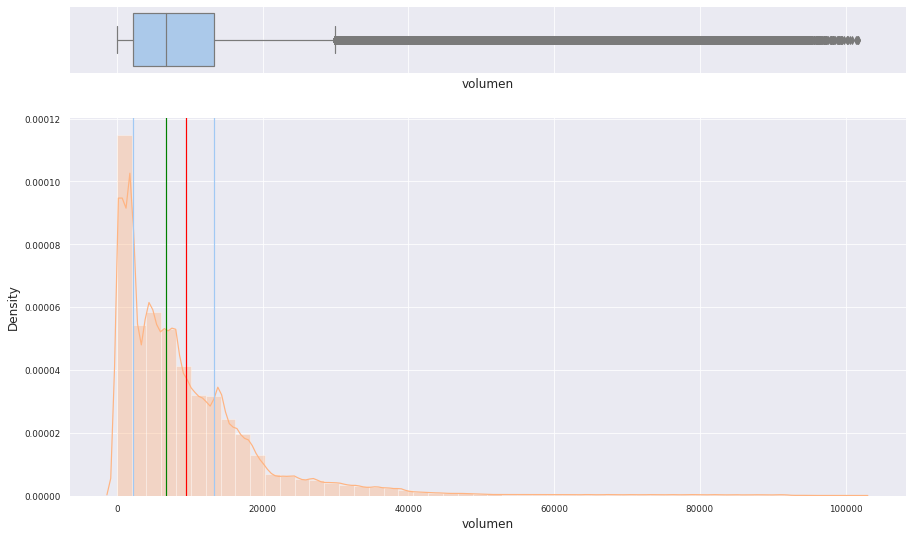

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(15,9),gridspec_kw={"height_ratios": (.15, .85)})
 
seaborn.boxplot(df.volumen, ax=ax_box)
seaborn.distplot(df.volumen, ax=ax_hist, kde=False, hist=False)
seaborn.distplot(df.volumen, ax=ax_hist, kde=True, hist=True,norm_hist=False)

plt.axvline(df.volumen.quantile(0.25))
plt.axvline(df.volumen.quantile(0.50),color='g')
plt.axvline(df.volumen.quantile(0.75))
plt.ticklabel_format(style='plain', axis='x') 
plt.axvline(df.volumen.mean(),color='red') 
ax_box.set_title
plt.show()

El gráfico de frecuencias y densidad de nuestra variable de interés (`volumen`), muestra que la distribución de los datos se encuentra sesgada hacia la izquierda, es decir que los datos se concentran mayormente en esta dirección. Esto podría deberse a las existencia de valores extremos (outliers) a la derecha de la distribución (asimetría derecha), o a la naturaleza de los datos. Esto será explorado en mayor detalle a continuación y en el próximo práctico de curación.

#### Filtrado por rango intercuartílico en el tiempo
Una técnica conocida para la eliminación de outliers de series temporales es el uso de la mediana móvil y los rangos intercuartílicos del `volumen` en ventanas de tiempo.

A diferencia del uso de la media móvil, la mediana parece ser más precisa en cuanto a eliminación de outliers, ya que la primera es más sensible a los valores extremos.

Primero debemos hacer que el `timestamp` sea nuestro nuevo index para poder aplicar ventanas de tiempo.

In [ ]:
df.set_index(pd.DatetimeIndex(df['timestamp']), inplace=True)
df.sort_index(inplace=True)

Calculamos la mediana móvil y los cuantiles 0.25 (q1) y 0.75 (q3) de la muestra. La ventana de tiempo elegida es de 2 minutos ya que observamos que este es un tiempo promedio de distancia entre puntos en la mayoría de los tanques. Se debe profundizar aún más en la elección de este gap según el tanque. 

In [ ]:
window = '2T'
df['moving_median'] = df.groupby('id_tanque')['volumen'].transform(
    lambda x: x.rolling(window, min_periods=2).median()
)
df['q1'] = df.groupby('id_tanque')['volumen'].transform(
    lambda x: x.rolling(window, min_periods=2).quantile(0.25)
)
df['q3'] = df.groupby('id_tanque')['volumen'].transform(
    lambda x: x.rolling(window, min_periods=2).quantile(0.75)
)
df['RI'] = df['q3'] - df['q1']
df['RI_min'] = df['q1'] - 1.5*df['RI']
df['RI_max'] = df['q3'] + 1.5*df['RI']

Veamos algún ejemplo en donde se encuentren puntos fuera de estos rangos.

In [ ]:
# Tomamos una muestra sobre uno de los tanques
# que vimos que tiene bastante ruido
point_sample = df.query("id_tanque == '102489' and volumen < RI_min").sample()

id_tanque = point_sample.iloc[0]['id_tanque']
timestamp = point_sample.iloc[0]['timestamp']

offset_timestamp = pd.DateOffset(hours=2)
before = str(timestamp - offset_timestamp)
after = str(timestamp + offset_timestamp)

point_sample

,id,id_equipo,id_tanque,volumen,temperatura,codigo,vbat1,vbat2,fuel_level_dmm,water_level_dmm,water_volume_lts,producto,temp5,temp4,temp3,temp2,temp1,id_empresa,current_firmware,id_canal,id_industria,industria,capacidad,alarma,nombre_producto,coef_var_vol,density,timestamp,c,echoes,max_echoes,moving_median,q1,q3,RI,RI_min,RI_max
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-06 12:02:53,359984,883,102489,8070.60,22.70,V1,56,312,13124.00,0.00,0.00,0,22.70,23.09,23.00,23.50,-56.09,1038,V71106WFc828353,10,1.00,Transportation,8100.00,False,DIESEL,0.00,0.00,2021-01-06 12:02:53,V,1,1.00,8158.39,8152.19,8161.03,8.84,8138.92,8174.30


In [ ]:
sample = df.query("""
    id_tanque == @id_tanque \
    and timestamp > @before \
    and timestamp < @after
""")
sample_outlier = df.query("""
    id_tanque == @id_tanque \
    and timestamp > @before \
    and timestamp < @after \
    and (volumen < RI_min or volumen > RI_max)
""")

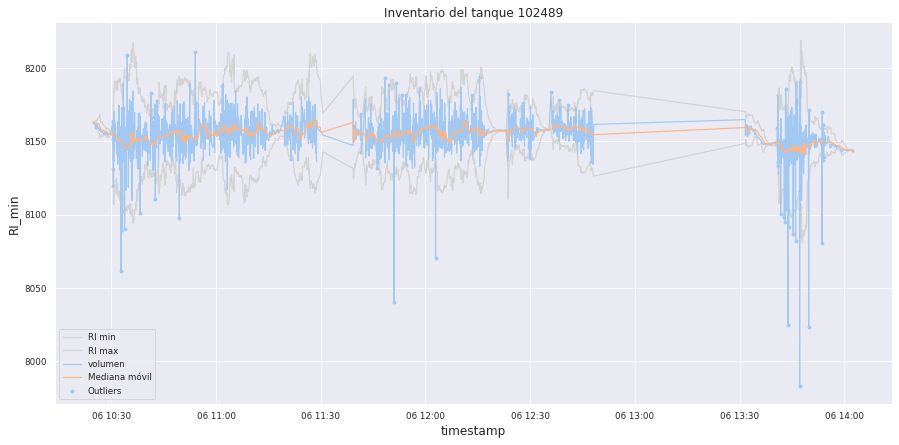

In [ ]:
fig = plt.figure(figsize=(15, 7))
seaborn.lineplot(
    data=sample, y='RI_min', x='timestamp',
    label='RI min', color='lightgray' 
)
seaborn.lineplot(
    data=sample, y='RI_max', x='timestamp', 
    label='RI max',  color='lightgray' 
)
seaborn.lineplot(
    data=sample, y='volumen', x='timestamp',
    label='volumen'
)
seaborn.lineplot(
    data=sample, y='moving_median', x='timestamp',
    label='Mediana móvil'
)
seaborn.scatterplot(
    data=sample_outlier, y='volumen', x='timestamp',
    label='Outliers',
)
plt.title(f'Inventario del tanque {id_tanque}')
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

Quitamos entonces los valores que superen el 1.5 veces el rango intercuarílico por ambos extremos.

In [ ]:
df = df.query("volumen >= RI_min")
df = df.query("volumen <= RI_max")
len(df)

6075067

Comparamos nuestra muestra antes y después de la eliminación de los puntos.

In [ ]:
sample_filtered = df.query("""
    id_tanque == @id_tanque \
    and timestamp > @before \
    and timestamp < @after
""")

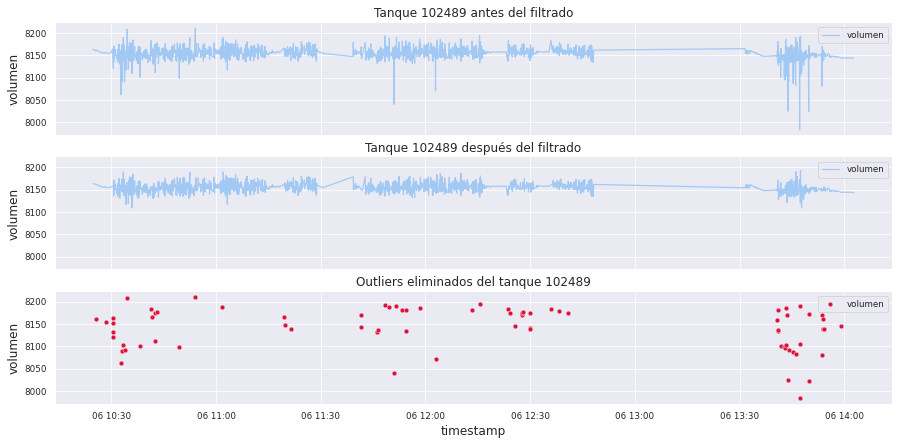

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(15, 7))
seaborn.lineplot(
    data=sample, y='volumen', x='timestamp',
    label='volumen', ax=axes[0]
)
seaborn.lineplot(
    data=sample_filtered, y='volumen', x='timestamp',
    label='volumen', ax=axes[1]
)
seaborn.scatterplot(
    data=sample_outlier, y='volumen', x='timestamp',
    label='volumen', color='crimson', ax=axes[2]
)
axes[0].set_title(f'Tanque {id_tanque} antes del filtrado')
axes[1].set_title(f'Tanque {id_tanque} después del filtrado')
axes[2].set_title(f'Outliers eliminados del tanque {id_tanque}')
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


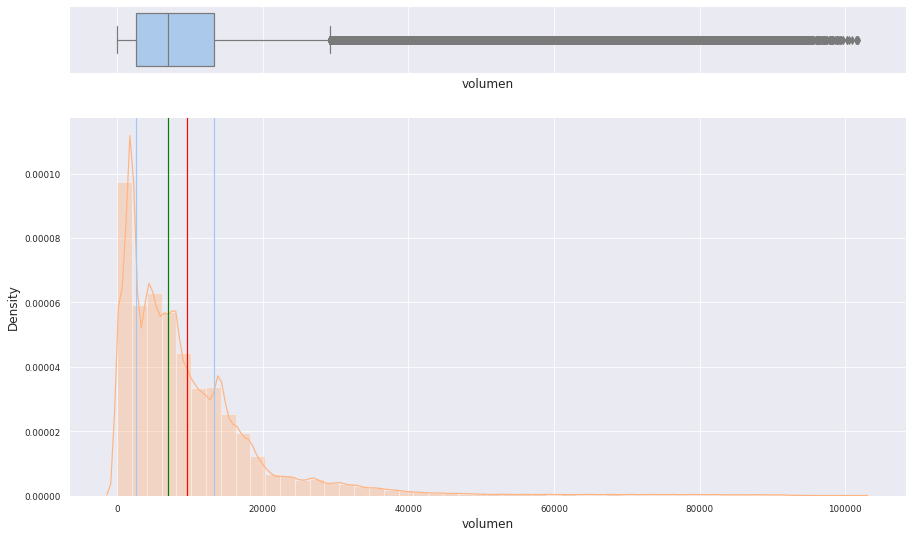

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(15,9),gridspec_kw={"height_ratios": (.15, .85)})
 
seaborn.boxplot(df.volumen, ax=ax_box)
seaborn.distplot(df.volumen, ax=ax_hist, kde=False, hist=False)
seaborn.distplot(df.volumen, ax=ax_hist, kde=True, hist=True,norm_hist=False)

plt.axvline(df.volumen.quantile(0.25))
plt.axvline(df.volumen.quantile(0.50),color='g')
plt.axvline(df.volumen.quantile(0.75))
plt.ticklabel_format(style='plain', axis='x') 
plt.axvline(df.volumen.mean(),color='red') 
ax_box.set_title
plt.show()

Al comparar los histogramas antes y después de aplicar la eliminación de outliers a través del método del rango intercuatílico de la mediana móvil, podemos observar que las gráficas siguen siendo similares. Es decir, la eliminación de outliers no fue lo suficientemente efectiva como para determinar cambios en la distribución de la variable. Es posible que exista una mayor cantidad de valores erróneos que aún no pudimos detectar y filtrar en este primer análisis exploratorio. En el próximo práctico se abordará en mayor detalle los valores erróneos y faltantes en nuestro dataset.

In [ ]:
df.describe()

,volumen,temperatura,vbat1,vbat2,fuel_level_dmm,water_level_dmm,water_volume_lts,temp5,temp4,temp3,temp2,temp1,capacidad,coef_var_vol,density,echoes,max_echoes,moving_median,q1,q3,RI,RI_min,RI_max
count,6075067.00,6075067.00,6075067.00,6075067.00,6058984.00,6058984.00,6058984.00,3741566.00,3741566.00,3741566.00,3741566.00,3617054.00,6075047.00,6037884.00,3507313.00,6075067.00,6075067.00,6075067.00,6075067.00,6075067.00,6075067.00,6075067.00,6075067.00
mean,9659.62,nan,61.37,299.83,8504.26,8.85,2.63,nan,nan,nan,nan,nan,20661.89,0.00,nan,1.11,1.11,9596.44,9536.95,9654.67,112.36,9458.70,9911.58
std,10585.59,0.00,5.23,30.72,5317.20,58.53,48.48,0.00,0.00,0.00,0.00,0.00,17785.30,0.01,0.00,0.32,0.32,10533.04,10502.74,10570.71,301.67,10413.22,10722.58
min,0.39,-56.59,17.00,160.00,8.00,0.00,0.00,-56.59,-56.59,-56.59,-56.59,-56.59,1.00,0.00,0.00,1.00,1.00,0.59,0.49,1.37,0.00,-49017.78,1.54
25%,2647.68,23.70,57.00,278.00,4360.00,0.00,0.00,24.09,-56.59,-56.59,-56.59,-56.59,8100.00,0.00,0.00,1.00,1.00,2635.32,2572.07,2662.00,0.47,2448.50,2807.31
50%,7021.56,25.80,61.00,300.00,8317.00,0.00,0.00,26.09,24.70,-56.50,-56.59,-56.59,20000.00,0.00,0.00,1.00,1.00,6955.14,6893.31,7018.23,11.61,6739.74,7203.82
75%,13260.51,27.70,66.00,311.00,12064.00,0.00,0.00,27.91,28.09,26.50,26.09,-55.69,21250.00,0.00,0.84,1.00,1.00,13162.93,13100.83,13226.00,73.33,12922.48,13397.02
max,101694.86,56.41,155.00,368.00,47825.00,9999.00,10000.00,56.41,51.81,59.00,54.81,55.09,102070.00,0.10,1.70,2.00,2.00,97882.41,97430.49,99028.60,34840.04,96074.76,113366.40


#### Distribución de los valores de temperatura

Las sondas contienen sensores de temperatura ubicados a distintas alturas. Estos sensores se corresponden con las columnas `temp1`, `temp2`, `temp3`, `temp4`, `temp5`, siendo la primera (`temp1`) la que se encuentra más arriba y la última (`temp5`) la que se encuentra más cerca del fondo del tanque. Estas alturas no son equidistantes y no todas las sondas contienen todos los sensores, pero sabemos que al menos la última (`temp5`) siempre está presente en la sonda.

La columna `temperatura` es una copia de la columna `temp5`, como se puede evidenciar en el siguiente boxplot.

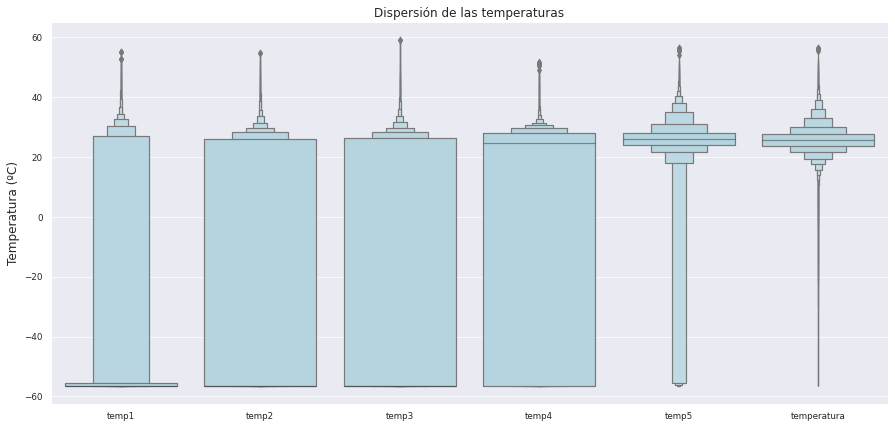

In [ ]:
fig = plt.figure(figsize=(15, 7))
seaborn.boxenplot(
    data=df[['temp1', 'temp2', 'temp3', 'temp4', 'temp5', 'temperatura']],
    color='lightblue'
)
plt.ylabel("Temperatura (ºC)")
plt.title("Dispersión de las temperaturas")
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

Se pueden observar muchas temperaturas con valores cercanos a -60. Esto nos puede indicar que el sensor de esa temperatura no funciona correctamente o no está presente en la sonda.

#### Distribución de la variable capacidad



In [ ]:
df.capacidad.describe()

count   6075047.00
mean      20661.89
std       17785.30
min           1.00
25%        8100.00
50%       20000.00
75%       21250.00
max      102070.00
Name: capacidad, dtype: float64

<Figure size 1080x504 with 0 Axes>

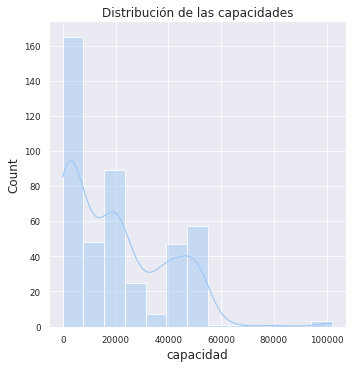

In [ ]:
fig = plt.figure(figsize=(15, 7))
seaborn.displot(
    data=df.groupby('id_tanque').first()['capacidad'],
    kde=True
)
plt.title("Distribución de las capacidades")
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

El histograma de frecuencias muestra una distribución multimodal y sesgada hacia la izquierda (asimetría derecha) de la variable `capacidad`, presentando un valor mínimo de 1 y un valor máximo de 102070.

#### Distribución de la variable nivel de combustible

In [ ]:
df.fuel_level_dmm.describe()

count   6058984.00
mean       8504.26
std        5317.20
min           8.00
25%        4360.00
50%        8317.00
75%       12064.00
max       47825.00
Name: fuel_level_dmm, dtype: float64

<Figure size 1080x504 with 0 Axes>

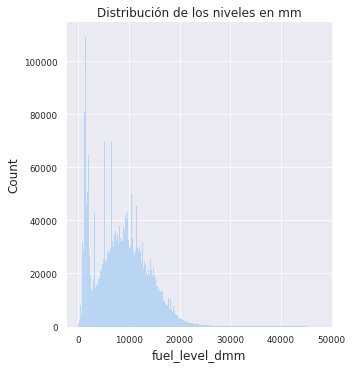

In [ ]:
plt.figure(figsize=(15, 7))
seaborn.displot(df.fuel_level_dmm)
plt.title("Distribución de los niveles en mm")
plt.ticklabel_format(style='plain', axis='x')  

El nivel de combustible (`fuel_level_dmm`) también posee una distribución sesgada a la izquierda (asimetría derecha), siendo el mínimo valor  8 y el máximo valor 47825. Asimismo, el 50% de los datos se concentra entre los valores 4360 y 12.064.

### Análisis de correlación entre las variables numéricas

Se realizan un análisis de correlación utilizando el método de Spearman ya que los datos no poseen distribución normal.

In [ ]:
# Eliminación de columnas que no se tendrán en cuenta en el análisis de correlación
df_drop = df.drop(["c","echoes","max_echoes", "moving_median","q1", "q3", "RI", "RI_min","RI_max"], axis=1)
df_cor = df_drop.corr(method="spearman")
df_cor

,volumen,temperatura,vbat1,vbat2,fuel_level_dmm,water_level_dmm,water_volume_lts,temp5,temp4,temp3,temp2,temp1,capacidad,alarma,coef_var_vol,density
volumen,1.00,-0.18,0.47,-0.07,0.85,-0.03,0.09,-0.09,0.43,0.32,0.44,0.22,0.76,0.07,-0.08,-0.15
temperatura,-0.18,1.00,-0.11,0.07,-0.15,-0.02,-0.05,0.95,0.12,-0.03,-0.08,-0.21,-0.17,-0.11,0.02,0.11
vbat1,0.47,-0.11,1.00,0.12,0.35,-0.14,-0.06,-0.06,0.56,0.27,0.36,0.08,0.59,0.36,-0.08,0.30
vbat2,-0.07,0.07,0.12,1.00,-0.18,-0.08,-0.20,0.07,0.26,0.13,0.05,0.33,-0.01,0.01,-0.02,0.36
fuel_level_dmm,0.85,-0.15,0.35,-0.18,1.00,-0.02,0.08,-0.12,0.48,0.39,0.42,0.24,0.50,0.03,-0.09,-0.10
water_level_dmm,-0.03,-0.02,-0.14,-0.08,-0.02,1.00,0.80,-0.21,-0.16,-0.06,-0.04,0.26,-0.05,-0.07,0.06,-0.12
water_volume_lts,0.09,-0.05,-0.06,-0.20,0.08,0.80,1.00,-0.20,-0.08,-0.00,-0.04,0.17,0.10,-0.14,0.04,-0.17
temp5,-0.09,0.95,-0.06,0.07,-0.12,-0.21,-0.20,1.00,0.17,0.01,-0.05,-0.21,-0.09,-0.19,0.04,0.09
temp4,0.43,0.12,0.56,0.26,0.48,-0.16,-0.08,0.17,1.00,0.54,0.45,0.21,0.52,0.06,-0.02,0.42
temp3,0.32,-0.03,0.27,0.13,0.39,-0.06,-0.00,0.01,0.54,1.00,0.83,0.58,0.26,-0.08,-0.09,-0.29


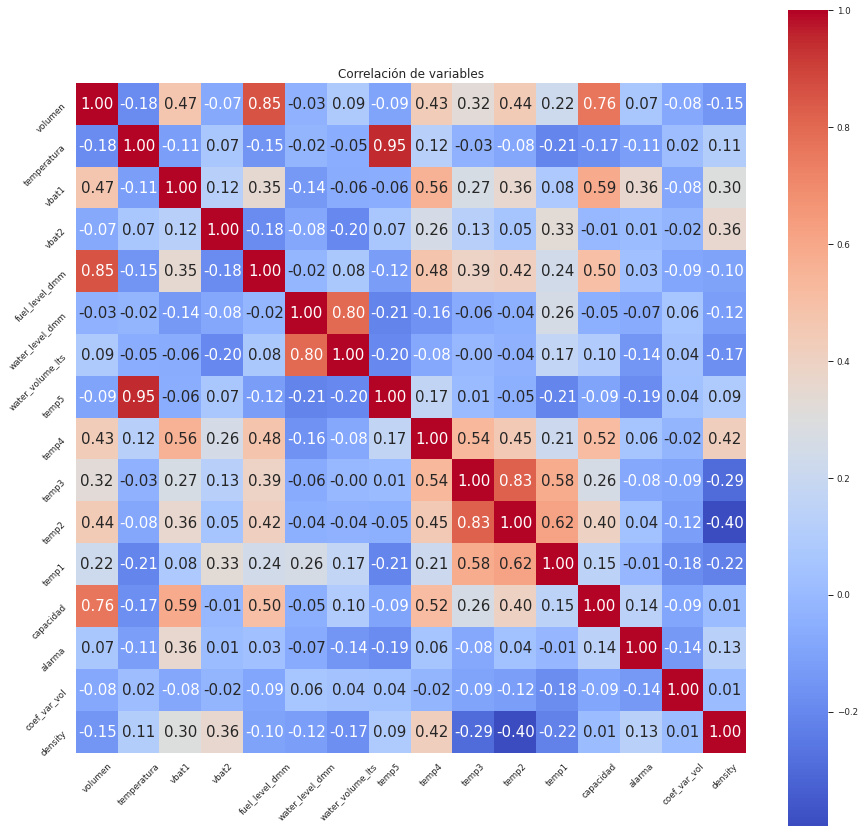

In [ ]:
plt.figure(figsize=(15,15))
seaborn.heatmap(df_cor, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title("Correlación de variables")
plt.show()

A partir del análisis de correlación entre las variables numéricas de nuestro dataset, pudimos observar una correlación alta entre las variables de temperatura ($r > 0.7$). Debido a que `temperatura` representa los mismos valores que `temp5`, sumado a que es la que indica la temperatura del combustible (a diferencia de las `temp1`, `temp2`, `temp3` y `temp4`) decidimos quedarnos con esta variable y desechar las otras. Por otra parte, observamos un alta correlación entre volumen y nivel de combustible ($r= 0.85$), que es lo que se espera ya que la variable volumen se calcula a partir de la variable nivel de combustible (`fuel_level_dmm`). De hecho, esperaríamos obtener una correlación igual a uno, sin embargo esta diferencia en el nivel de correlación podría deberse a un error de cálculo a partir de la tabla de calibración. En este caso, nos quedaríamos con la variable volumen ya que es la que nos aporta la información necesaria para responder a las preguntas planteadas. Por otra parte, existe una correlación alta entre `volumen` y `capacidad` ($r = 0.76$), lo cual es esperable, sin embargo la variable `capacidad` nos provee información que la variable `volumen` no nos da, por lo que decidimos mantenerla en nuestro dataset por el momento. Por último, se puede observar una correlación alta entre `water_volume_lts` y `water_level_dmm`($ r=0.80 $). Por la misma razón que en el caso del combustible, decimos quedarnos con el volumen de agua.

### Comparacion de variables

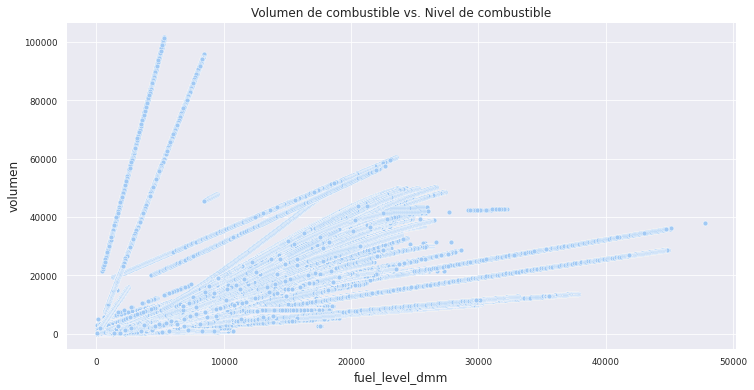

In [ ]:
plt.figure(figsize=(12, 6))
seaborn.scatterplot(data=df,x="fuel_level_dmm", y="volumen")
plt.title("Volumen de combustible vs. Nivel de combustible")
plt.ticklabel_format(style='plain')

A partir del scatterplot podemos corroborar la alta correlación que existe entre `volumen`y `fuel_level_dmm`, pudiendo observar una relación directa y positiva entre estas dos variables. Sin embargo, se detectan volumenes altos a niveles de combustible bajo lo cual podría esta evidenciando la posible existencia de valores atípicos o erróneos.

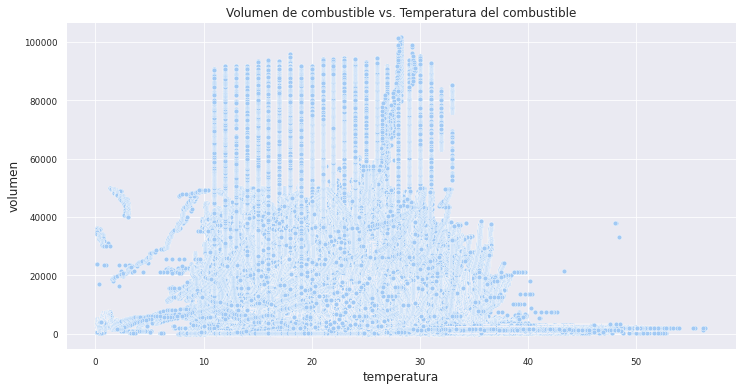

In [ ]:
plt.figure(figsize=(12, 6))
seaborn.scatterplot(data=df[df["temperatura"] > 0], y="volumen", x="temperatura")
plt.title("Volumen de combustible vs. Temperatura del combustible")
plt.ticklabel_format(style='plain')

A partir de este gráfico se puede observar que no existe una relación clara entre las variables `volumen`y `temperatura`. La mayoría de los datos se concentran entre los 10 y 35 °C.  

In [ ]:
df.industria.value_counts()

Service Station    3309300
Transportation     1495392
Construction        314186
Telcos              311756
Oil&Gas             170806
Industry            160992
Agriculture         115056
Mining               49379
Public                2603
Distributor            223
Name: industria, dtype: int64

Debido a que las industrias `Public` y `Distributor` poseen muy pocas observaciones decidimos, por el momento, agruparlas en la categoría "Otras"

In [ ]:
df["industria"] = numpy.where((df.industria=="Public")|(df.industria=="Distributor"), "Otras", df.industria)

In [ ]:
df.industria.dropna().unique()

array(['Telcos', 'Service Station', 'Transportation', 'Agriculture',
       'Construction', 'Oil&Gas', 'Industry', 'Mining', 'Otras'],
      dtype=object)

Text(0.5, 1.0, 'Dispersión de volumen por industria')

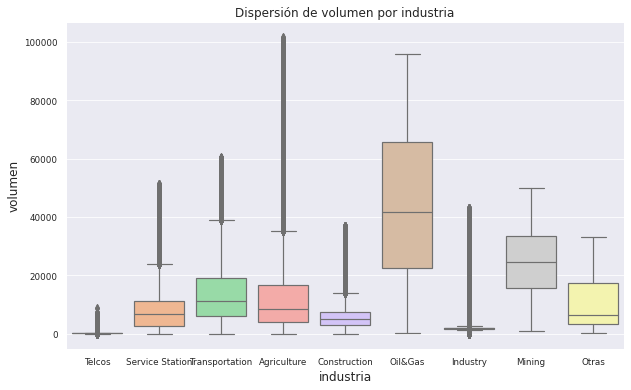

In [ ]:
plt.figure(figsize=(10,6))
seaborn.boxplot(data=df, x= "industria", y="volumen")
plt.title("Dispersión de volumen por industria")

En este boxplot podemos observar la presencia de valores extremos (outliers) en casi todas las categorías de industria (excepto Oil&Gas), lo que sugiere la necesidad de realizar un tratamiento de outliers al momento de analizar cada una de las industrias por separado. Esto se abordará en el siguiente práctico de curación. Además, este gráfico muestra que la industria Oil&Gas presenta un mayor inventario (`volumen`) de combustible, seguido por las industrias Minera y de Transporte.

In [ ]:
df.nombre_producto.value_counts()[:10]

Diesel                1215872
Formula Diesel         568774
DIESEL                 530710
Diesel 500             518756
Nafta Super            398338
Super                  363929
Gas Oil Comun Gr 2     246291
VP Diesel              244912
Product 1              233252
VP Nafta               228507
Name: nombre_producto, dtype: int64

Debido a la gran cantidad de categorías de cobustibles decidimos, por lo pronto, quedarnos con las seis más frecuentes y las categorizamos en dos productos "Diesel" y "Nafta"

In [ ]:
df["nombre_producto"]= numpy.where((df.nombre_producto=="Diesel")|(df.nombre_producto=="DIESEL")|(df.nombre_producto=="Diesel 500")|(df.nombre_producto=="Formula Diesel"), "Diesel", 
                                   numpy.where((df.nombre_producto=="Nafta Super")| (df.nombre_producto=="Super"), "Nafta", df.nombre_producto))

In [ ]:
df.nombre_producto.value_counts()

Diesel                       2834112
Nafta                         762267
Gas Oil Comun Gr 2            246291
VP Diesel                     244912
Product 1                     233252
VP Nafta                      228507
GASOIL                        158927
Infinia Diesel                132078
Gas Oil                       119040
Infinia Nafta                 118009
D500                          102914
Product 2                     100014
Producto 0                     91244
V-Power Nafta                  83012
Producto 1                     76851
ULTRA DIESEL                   52170
VP-Diesel                      50530
V-Power Diesel                 49909
Formula                        45416
VP-Nafta                       42966
UREA                           33167
Gasoil                         32019
Diesel Comun                   31788
DIESEL EURO                    29250
Gas Oil Euro Gr 3              23910
Euro                           20935
Gas Oil Grado 2                12359
Q

Text(0.5, 1.0, 'Distribución Diesel y Nafta')

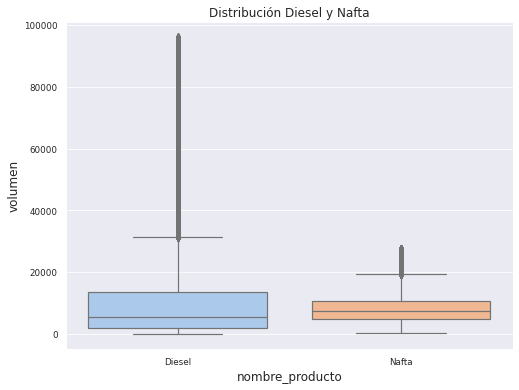

In [ ]:
plt.figure(figsize=(8,6))
seaborn.boxplot(data=df[(df.nombre_producto== "Diesel") | (df.nombre_producto == "Nafta")], x= "nombre_producto", y="volumen")
plt.title("Distribución Diesel y Nafta")

Al igual que en el caso de las industrias, podemos observar que la distribución de las categorías de  combustibles (`nombre_producto`) Diesel y Nafta se encuentra sesgada hacia la izquierda con presencia de outliers hacia la derecha. Este gráfico muestra una tendencia general de mayor inventario (`volumen`) de nafta en relación al diesel. Sin embargo, esta diferencia puede estar influenciada por la cantidad de observaciones que presentan ambas categorías, siendo mucho menor para el caso de la nafta.

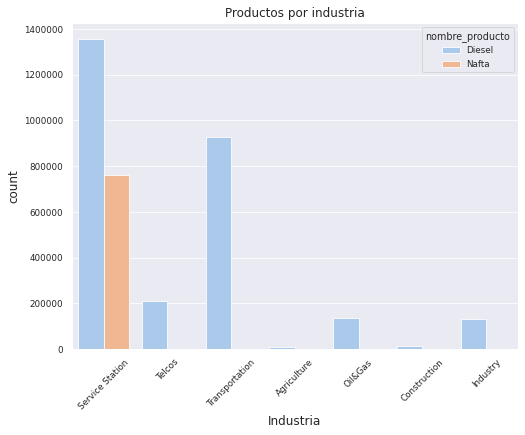

In [ ]:
plt.figure(figsize=(8,6))
seaborn.countplot(data=df[(df.nombre_producto== "Diesel") | (df.nombre_producto == "Nafta")], x= "industria", hue="nombre_producto")
plt.xticks(rotation=45)
plt.xlabel("Industria")
plt.title("Productos por industria")
plt.ticklabel_format(style='plain', axis='y')

In [ ]:
data=df[(df.nombre_producto== "Diesel") | (df.nombre_producto == "Nafta")]
pd.crosstab(data.industria, data.nombre_producto)

nombre_producto,Diesel,Nafta
industria,,
Agriculture,10297,0
Construction,14065,0
Industry,133711,0
Oil&Gas,138060,0
Service Station,1358086,762267
Telcos,208652,0
Transportation,928008,0


A partir del gráfico de conteo podemos observar que todas las industrias poseen inventarios de Diesel, aunque el número de observaciones (tanques) varía según la industria. Por su parte, solo la industria (`Service Station`) posee inventario de Nafta, corroborando de esta manera la existencia de una menor cantidad de observaciones para la categoría nafta, lo cual se puede observar también en la crosstab.  

### Selección de columnas relevantes

Una vez explorado y limpiado nuestro dataset, viendo las correlaciones entre ellas y las distribuciones, eliminamos columnas que no serán relevantes para los siguientes análisis.

In [ ]:
columns = [
    'id', 'alarma', 'density','fuel_level_dmm', 'temp1', 'temp2', 
    'temp3', 'temp4', 'temp5', 'water_level_dmm'
]
df.drop(columns=columns, inplace=True)

### Agrupación de inventarios

Para poder visualizar correctamente un inventario en el tiempo es necesario poder separar los registros por tanque (o sonda) ya que cada registro es completamente independiente del resto de los casos.

Filtramos uno de los tanques por `id_tanque` y lo visualizamos.

In [ ]:
sample_tank = df.query("""
    id_tanque == '500' \
    and timestamp > '2021-01-01' \
    and timestamp < '2021-02-01'
""")

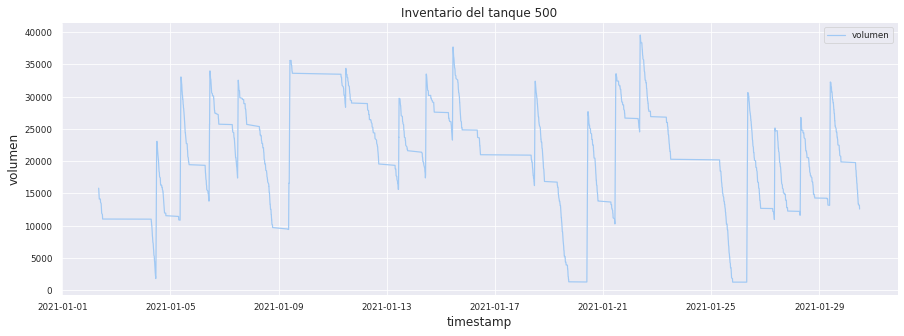

In [ ]:
fig = plt.figure(figsize=(15, 5))
seaborn.lineplot(
    data=sample_tank, y='volumen', x='timestamp', 
    label='volumen'
)
plt.title(f'Inventario del tanque 500')
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

Otras agrupaciones que pueden resultar útiles al momento de analizar características del dataset pueden ser por `producto`, `id_equipo`, `id_industria`, `id_canal`, rango de `capacidad`es.

### Uniformidad de tiempo de los datos

A partir del siguiente análisis buscamos detectar gaps temporales entre muestras. El código presenta todos aquellos tanques (`id_tanques`) que poseen gaps entre muestras con más de 1 hora, junto a la media de los gaps y el desvío stándar. El código se deja planteado para ser utilizado en próximos análisis y que nos permita separar rápidamente tanques que requieren o no imputación.

In [ ]:
#se arma un array con los id_tanque
tanques_unique=df.id_tanque.unique()
for tanque in tanques_unique:
    # Tomar la diferencia del timestamp y no tener en cuenta la primer fila ya que no tiene diff hacia atrás
    deltas = df[df['id_tanque']==tanque].timestamp.diff()[1:]

    # Filtrar diffs mayores al valor introducido (pueden ser dias, horas, minutos, etc) 
    gaps = deltas[deltas > timedelta(hours=1)]

    #Resultados
    if len(gaps) != 0:
        print(f'Tanque ID:{tanque} tiene {len(gaps)} gaps con duración promedio: {gaps.mean()} y std: {gaps.std()}')
        #descomentar para ampliar información de los gaps
        #for i, g in gaps.iteritems():
        #    gap_start = df['timestamp'][i - 1]
        #    print(f'Start: {datetime.strftime(gap_start, "%Y-%m-%d")} | '
        #          f'Duration: {str(g.to_pytimedelta())}')

Tanque ID:101855 tiene 1 gaps con duración promedio: 6 days 00:20:29 y std: NaT
Tanque ID:102294 tiene 4 gaps con duración promedio: 3 days 01:05:54.500000 y std: 3 days 13:53:36.058376124
Tanque ID:1013 tiene 10 gaps con duración promedio: 0 days 04:06:20.800000 y std: 0 days 04:02:54.399921323
Tanque ID:101998 tiene 1 gaps con duración promedio: 29 days 08:00:28 y std: NaT
Tanque ID:1010 tiene 2 gaps con duración promedio: 0 days 01:29:43.500000 y std: 0 days 00:35:30.512731715
Tanque ID:101597 tiene 1 gaps con duración promedio: 0 days 01:02:37 y std: NaT
Tanque ID:102138 tiene 126 gaps con duración promedio: 0 days 07:11:36.507936507 y std: 1 days 03:35:10.830650900
Tanque ID:1133 tiene 179 gaps con duración promedio: 0 days 10:01:21.474860335 y std: 0 days 07:17:59.015521920
Tanque ID:988 tiene 367 gaps con duración promedio: 0 days 03:01:44.956403269 y std: 0 days 04:42:25.889822707
Tanque ID:430 tiene 98 gaps con duración promedio: 0 days 02:01:35.285714285 y std: 0 days 01:51:4

### Resampling del timeseries

Alternativamente al código anterior para verificación de espacios de tiempos sin muestras, se puede realizar un análisis similar con UPsampling. El siguiente código aplica un resampling definido en la variable n y separa en dos dictionary los tanques que permiten upsampling (es decir, que no generar NaN en periodos n) y los que necesitan imputación. Con n=30 minutos se puede verificar que el 96% de los casos deberá aplicarse imputación. Por supuesto que hay tanques (si evaluamos desde los tanques y no desde otra variable como tipo de combustible) que incluyen muy pocas muestras y se deberá tomar una desición al respecto (si dejarlos o eliminarlos). 

In [ ]:
df_upsampling=df.copy()
#set timestamp as index
df_upsampling = df_upsampling.set_index('timestamp')
#minutos de resampling
n='30min'
#dictionary con tanques que aceptan upsampling sin imputación
dic_tanques_upsampling_n={}
#dictionary con tanques que requieren imputación
dic_tanques_imputaction_n={}
for tanque in tanques_unique:
    volumen_diario = df_upsampling[df_upsampling['id_tanque']==tanque].volumen.resample(n).mean()
    key='key'+str(tanque)
    if volumen_diario.isna().sum() == 0:
        dic_tanques_upsampling_n[key]=df_upsampling[df_upsampling['id_tanque']==tanque].volumen.copy()
    else:
        dic_tanques_imputaction_n[key]=df_upsampling[df_upsampling['id_tanque']==tanque].volumen.copy()

Para entender los métodos de imputación y sus resultados, a continuación realizamos algunas pruebas con una id_tanque con posee 11 gaps con un promedio de aproximandamente 2 dáas.
En el siguiente scatterplot observamos el gap más importante que son 11 días, comenzando el 2021-03-06. 

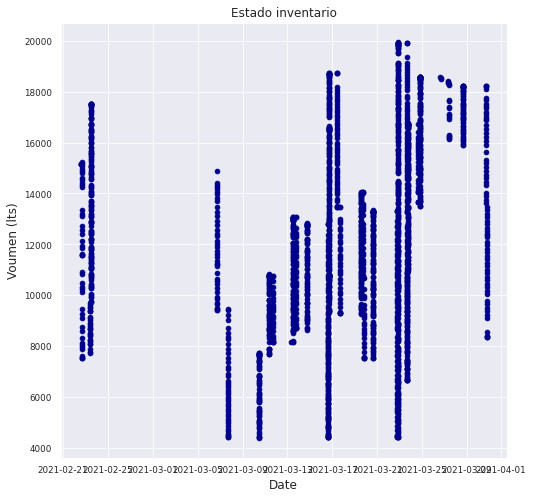

In [ ]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(8, 8))
# Add x-axis and y-axis
ax.scatter(df_upsampling[df_upsampling['id_tanque']=='103092'].index.values,
           df_upsampling[df_upsampling['id_tanque']=='103092'].volumen,
           color='darkblue')
# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Voumen (lts)",
       title="Estado inventario")
plt.show()

A continuación aplicamos imputación con dos métodos distintos: líneal y polinómico de grado 2. Los resultados son distintos, brindando el segundo imputaciones más suaves. Se incluye también un polinomio de grado 5 (máximo para este método) y es interesante observar como se generan valores negativos y picos que no tienen relación con la muestra origial. Se deberá profundizar al respecto. 

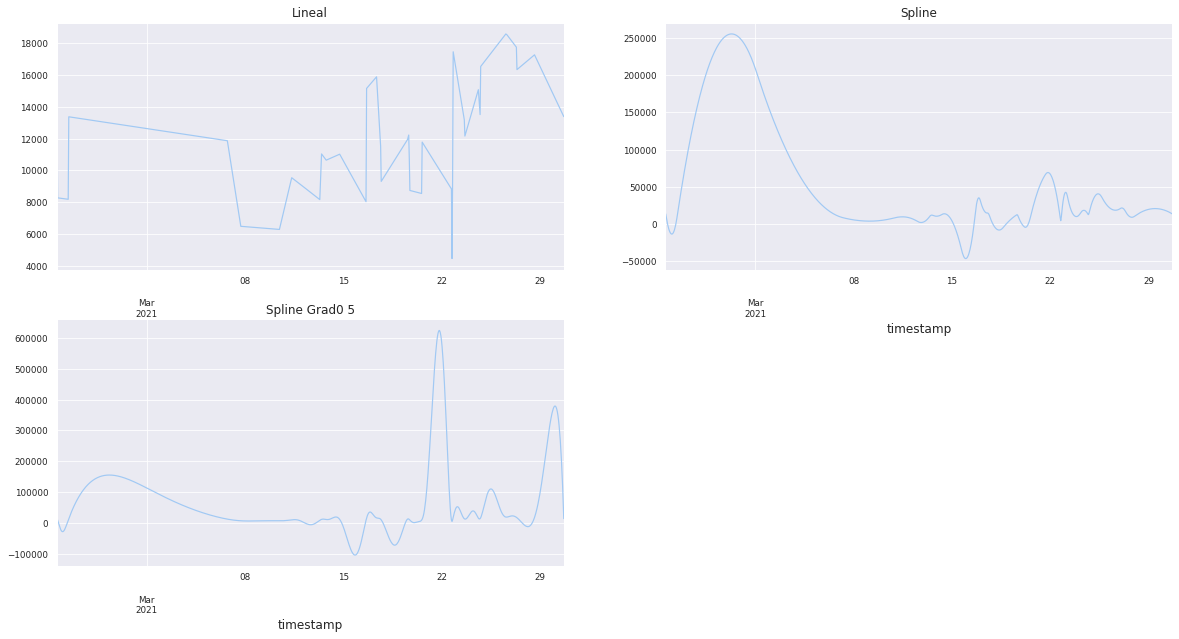

In [ ]:
interpolado_lineal=df_upsampling[df_upsampling['id_tanque']=='103092'].resample('60min').mean().interpolate(method='linear')
interpolado_spline=df_upsampling[df_upsampling['id_tanque']=='103092'].resample('60min').mean().interpolate(method='spline', order=2)
interpolado_spline_5=df_upsampling[df_upsampling['id_tanque']=='103092'].resample('60min').mean().interpolate(method='spline', order=5)
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
interpolado_lineal.volumen.plot()
plt.title('Lineal')
plt.subplot(2, 2, 2)
interpolado_spline.volumen.plot()
plt.title('Spline')
plt.subplot(2, 2, 3)
interpolado_spline_5.volumen.plot()
plt.title('Spline Grad0 5')
plt.show()

### Normalización de valores

Para poder realizar algunas operaciones es necesario normalizar algunas de estas columnas. Se dejan algunas de ellas, las cuales serán cubiertas en profundidad en el trabajo de curación de datos.

#### Ajuste del `volumen` por dilatación térmica

El volumen aumenta o disminuye debido la **dilatación térmica**. Esta relación viene dada por:

<center>
$\alpha = {\Delta V\over V_0 \Delta T}$
</center>

donde:
- $T$ es la `temperatura`.
- $V$ es el `volumen`.

Este ajuste se realiza entonces comepensando el volumen a una temperatura seleccionada:

<center>
$V_f=\alpha*V_0*(T_f-T_0)$
</center>

donde:
- $T_0$ y $V_0$ son la `temperatura` y `volumen` registrados.
- $T_f$ es la temperatura a la cual compensar.
- $V_f$ es el volumen compensado.



#### Ajuste del `volumen` restando volumen de agua (`water_volume_lts`)

Si las sondas contienen dos boyas de medición, el `volumen` de combustible se ve afectado por la segunda medición (agua). Esto se puede ajustar restando el volumen del agua al volumen del combustible.

Adicionalmente el agua también puede ser ajustado por **dilatación térmica**.

## Análisis

Luego del análisis exploratorio de las distitas features, comenzamos a analizar con mayor detalle el comportamiento de los datos según las distintas agrupaciones. Nos focalizamos en la observación de los comportamientos de los inventarios (registros históricos de volúmen) y los consumos.

### Inventarios sobre centros operativos

Se seleccionan algunos centros operativos para analizar el comportamiento de sus inventarios. Para esto, usaremos como muestra un `id_equipo`. Para visualizar un centro operativo, es necesario separar los valores por `id_tanque`, ya que cada uno es independiente del otro. No puede realizarse una agregación entre ellos, ya que por el momento los tiempos de todo el conjunto de datos no es uniforme.

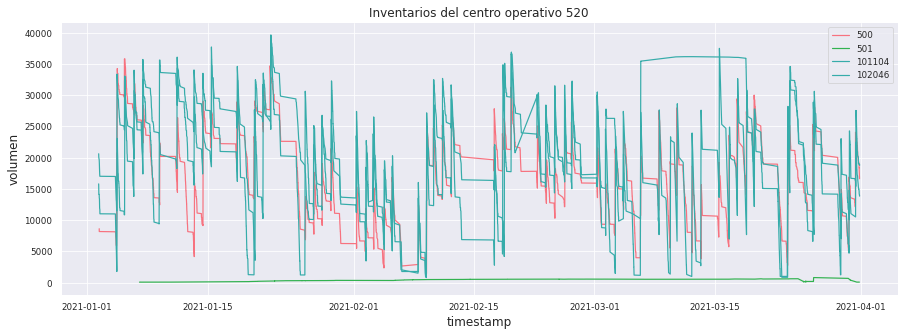

In [ ]:
id_equipo = '520'
sample = df.query("id_equipo == @id_equipo")

fig = plt.figure(figsize=(15, 5))
seaborn.lineplot(
    data=sample, y='volumen', x='timestamp', hue='id_tanque'
)

plt.title(f"Inventarios del centro operativo {id_equipo}")
plt.legend(labels=sample['id_tanque'].unique())
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

### Descriptores estadísticos de los inventarios

Analizamos los descriptores estadísticos sobre cada uno de los inventarios y graficamos algunos casos en particular.


#### Medidas de centralización

Observamos los tanques con menor y mayor media y mediana.

In [ ]:
# Media
mean = df.groupby('id_tanque')['volumen'].mean().sort_values().dropna()
mean.take([0, -1])

id_tanque
103224      30.10
940      56745.12
Name: volumen, dtype: float32

In [ ]:
# Mediana
median = df.groupby('id_tanque')['volumen'].median().sort_values().dropna()
median.take([0, -1])

id_tanque
103224      30.10
940      57839.10
Name: volumen, dtype: float32

#### Medidas de dispersión

Calculamos la dispersión de cada inventario y observamos los que tienen menor y mayor dispersión.

In [ ]:
# Varianza
var = df.groupby('id_tanque')['volumen'].var().sort_values().dropna()
var.take([0, -1])

id_tanque
1028           0.00
941    467223072.00
Name: volumen, dtype: float32

In [ ]:
# Desviación estándar
std = df.groupby('id_tanque')['volumen'].std().sort_values().dropna()
std.take([0, -1])

id_tanque
1028       0.00
941    21615.34
Name: volumen, dtype: float64

In [ ]:
# Coeficiente de variación
coef_var = (std / mean).sort_values().dropna()
coef_var.take([0, -1])

id_tanque
103264   0.00
102331   1.82
Name: volumen, dtype: float64

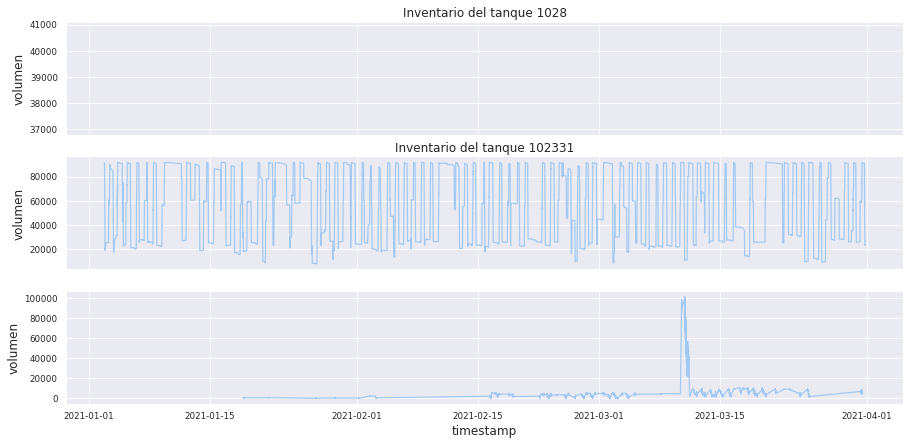

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(15, 7))
seaborn.lineplot(data=df.query("id_tanque == '1028'")['volumen'], ax=axes[0])
seaborn.lineplot(data=df.query("id_tanque == '941'")['volumen'], ax=axes[1])
seaborn.lineplot(data=df.query("id_tanque == '102331'")['volumen'], ax=axes[2])
axes[0].set_title("Inventario del tanque 1028")
axes[1].set_title("Inventario del tanque 941")
axes[1].set_title("Inventario del tanque 102331")
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

Observamos que:
- Los tanques con poca desviación estándar no tienen movimientos de inventario o presentan pocos puntos.
- Los tanques con mucha desviación estándar se encuentran constantemente en movimiento.
- Los tanques con alto coeficiente de variación presentan movimientos inusuales.

### Descriptores estadísticos de los estadísticos de los inventarios

In [ ]:
# Promedio de las medias de los inventarios
df.groupby('id_tanque')['volumen'].mean().mean()

9443.1005859375

In [ ]:
# Promedio de las mendianas de los invetarios
df.groupby('id_tanque')['volumen'].median().mean()

9455.0419921875

Los tanques, en promedio, se encuentra en un nivel de combustible cercano a los 9500 litros. 

In [ ]:
# Promedio de las desviaciones estándar de los invetarios
df.groupby('id_tanque')['volumen'].var().mean()

24451310.0

In [ ]:
# Promedio de las desviaciones estándar de los invetarios
df.groupby('id_tanque')['volumen'].std().mean()

3344.3657685156545

En promedio se observa poco movimiento de inventarios (en comparación al de mayor dispersión).

In [ ]:
# Promedio de los coeficientes de variación de los invetarios
(df.groupby('id_tanque')['volumen'].std() / df.groupby('id_tanque')['volumen'].mean()).mean()

0.34072742654824145

No se observan demasiados comportamientos inusuales en la mayoría de los inventarios (comparado con el de mayor coeficiente de variación).

### Patrones de manejo de inventario por industria

In [ ]:
df_ind=df[["volumen", "industria"]].groupby("industria").describe()
df_ind

volumen                    ...                            
                     count     mean      std  ...      50%      75%       max
industria                                     ...                            
Agriculture      115056.00 11684.25 10938.62  ...  8592.88 16548.77 101694.86
Construction     314186.00  6001.20  4761.97  ...  4865.20  7514.35  37082.47
Industry         160992.00  4767.65  8077.19  ...  1981.88  2018.90  43149.80
Mining            49379.00 24533.59 11125.05  ... 24646.53 33354.00  50040.02
Oil&Gas          170806.00 43853.33 25600.52  ... 41576.11 65607.69  96080.95
Otras              2826.00 10403.37  8978.14  ...  6392.00 17244.55  33244.43
Service Station 3309300.00  7583.48  5260.08  ...  6593.92 11160.36  51287.85
Telcos           311756.00   224.63   281.18  ...   198.62   224.71   8642.22
Transportation  1495392.00 13503.06  9920.75  ... 11232.18 19122.09  60506.25

[9 rows x 8 columns]

In [ ]:
df_ind.columns = df_ind.columns.droplevel(level=0)
df_ind.sort_values(by='50%',ascending=False)

,count,mean,std,min,25%,50%,75%,max
industria,,,,,,,,
Oil&Gas,170806.00,43853.33,25600.52,294.32,22477.86,41576.11,65607.69,96080.95
Mining,49379.00,24533.59,11125.05,971.84,15651.00,24646.53,33354.00,50040.02
Transportation,1495392.00,13503.06,9920.75,0.46,5957.09,11232.18,19122.09,60506.25
Agriculture,115056.00,11684.25,10938.62,2.64,4144.00,8592.88,16548.77,101694.86
Service Station,3309300.00,7583.48,5260.08,26.00,2716.66,6593.92,11160.36,51287.85
Otras,2826.00,10403.37,8978.14,172.99,3281.25,6392.00,17244.55,33244.43
Construction,314186.00,6001.20,4761.97,4.93,3119.60,4865.20,7514.35,37082.47
Industry,160992.00,4767.65,8077.19,12.60,1655.80,1981.88,2018.90,43149.80
Telcos,311756.00,224.63,281.18,0.39,149.30,198.62,224.71,8642.22


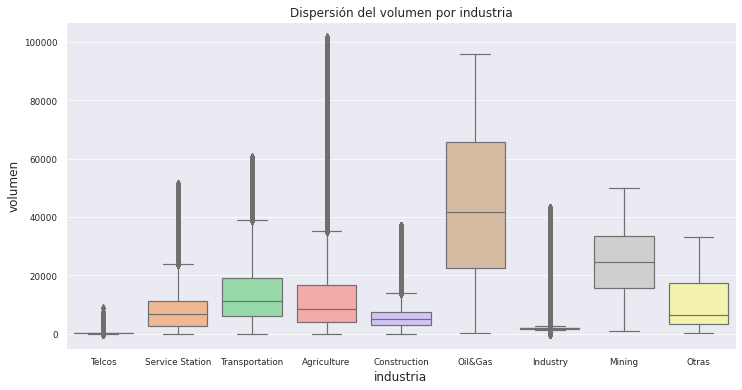

In [ ]:
plt.figure(figsize=(12,6))
plt.title("Dispersión del volumen por industria")
seaborn.boxplot(data=df, x="industria", y="volumen")

El boxplot muestra que la industria Oil&Gas presenta un mayor inventario (`volumen`) de combustible, seguido por las industrias Minera y de Transporte.

Se analizará gráficamente el patrón de inventarios por industria en el tiempo (por hora, día y mes)

In [ ]:
df_ind_resa=df.groupby("industria").resample("1H", on="timestamp").mean().reset_index()

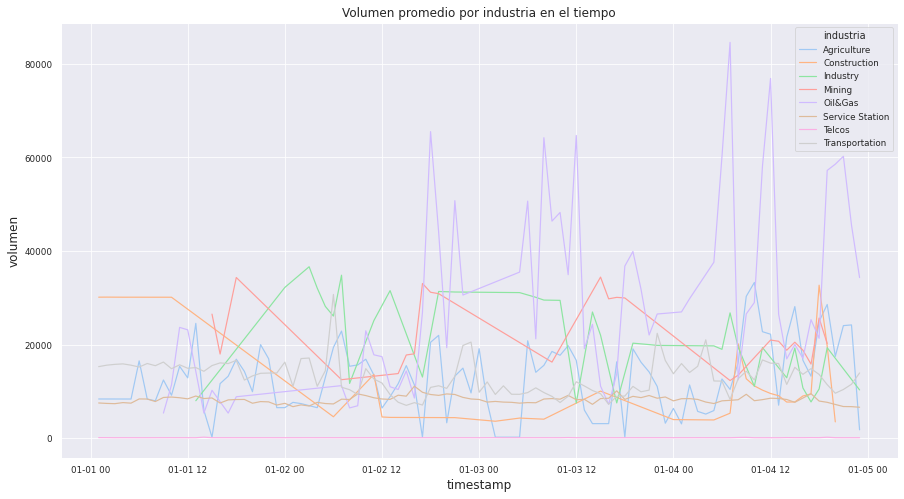

In [ ]:
df_ind_resa=df_ind_resa[(df_ind_resa["timestamp"] > "2021-01-01") & (df_ind_resa["timestamp"] < "2021-01-05")]
plt.figure(figsize=(15,8))
plt.title("Volumen promedio por industria en el tiempo")
seaborn.lineplot(data=df_ind_resa, x="timestamp", y="volumen", hue="industria")

Análisis por día.

In [ ]:
df_ind_resa=df.groupby("industria").resample("D", on="timestamp").mean().reset_index()

In [ ]:
df_ind_resa=df_ind_resa[(df_ind_resa["timestamp"] > "2021-01-01") & (df_ind_resa["timestamp"] < "2021-01-10")]

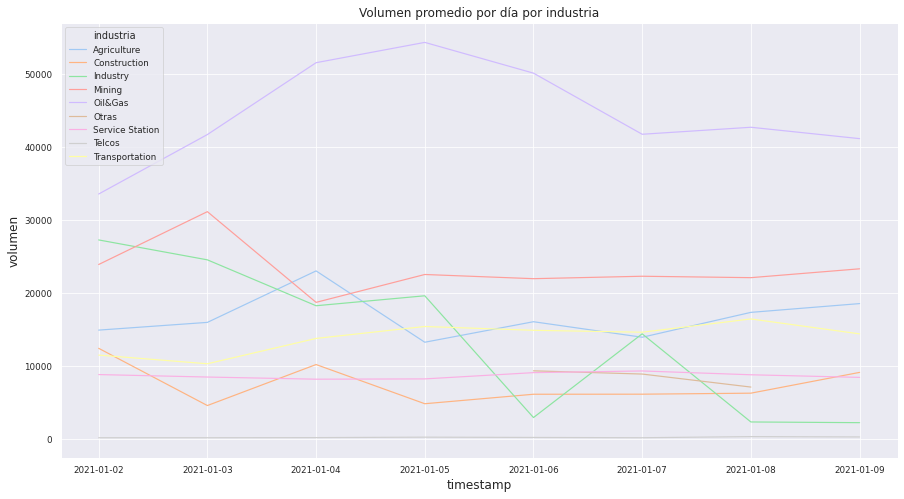

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Volumen promedio por día por industria")
seaborn.lineplot(data=df_ind_resa, x="timestamp", y="volumen", hue="industria")

Análisis por mes.

In [ ]:
df_ind_resa=df.groupby("industria").resample("M", on="timestamp").mean().reset_index()

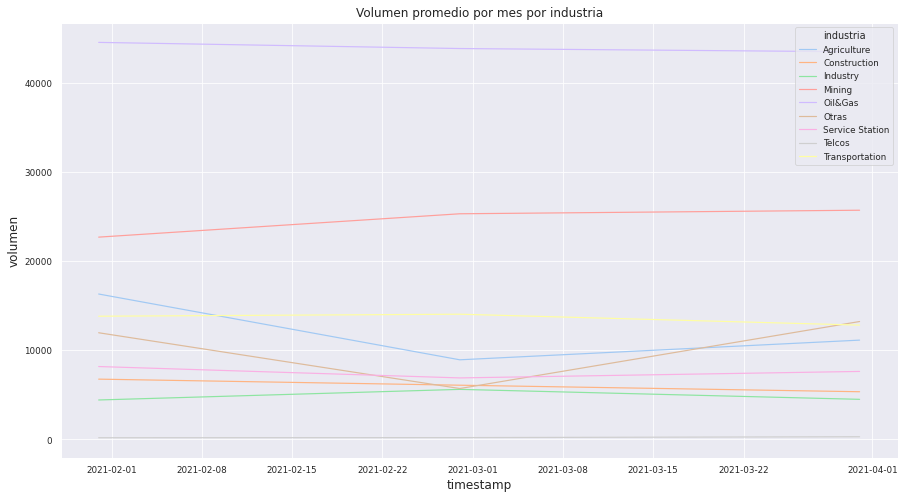

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Volumen promedio por mes por industria")
seaborn.lineplot(data=df_ind_resa, x="timestamp", y="volumen", hue="industria")

A partir de estos gráficos, podemos observar una variación del inventarios de combustibles que depende de la industria considerada. Las variaciones por hora en los patrones de inventarios parecen ser más pronunciadas para industrias como Oil&Gas y Agricultura, más atenuadas para minería y construcción y casi nulas para la industria de telecomunicaciones. Cuando tenemos en cuenta las variaciones diarias, y más aún las mensuales, el patrón de inventario para la industria Oil&Gas de atenúa.

### Patrones de manejo de inventario por producto


In [ ]:
df_pro=df[["volumen", "nombre_producto"]].groupby("nombre_producto").describe()

In [ ]:
df_pro.columns = df_pro.columns.droplevel(level=0)
df_pro.sort_values(by='50%',ascending=False)

,count,mean,std,min,25%,50%,75%,max
nombre_producto,,,,,,,,
Ultra-Diesel,50.00,44926.09,8089.08,30550.13,37351.69,44460.49,51146.46,59622.99
GAS OIL,2384.00,35898.77,9394.08,7707.00,30493.07,37119.22,43380.07,48724.84
Euro,20935.00,24323.94,8922.34,904.76,18528.68,24575.10,31034.76,41428.80
Gas Oil,119040.00,21260.78,11637.15,4.93,13129.70,21613.36,29756.32,50040.02
Gasoil grado 2,8948.00,21379.13,10651.27,882.39,12270.64,21079.41,30246.78,43149.80
Diesel Comun,31788.00,20267.30,9537.69,948.91,13034.00,20334.27,27106.12,43015.17
Euro-Diesel,21.00,19986.41,2794.89,10283.40,18925.65,20276.00,21685.50,23014.20
ULTRA DIESEL,52170.00,19882.26,8040.05,787.72,14204.00,20246.74,25925.00,39631.75
Glifosato,5.00,18246.00,0.00,18246.00,18246.00,18246.00,18246.00,18246.00


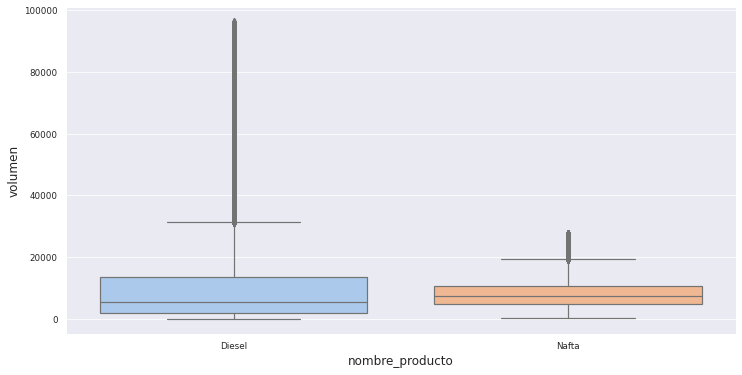

In [ ]:
plt.figure(figsize=(12,6))
seaborn.boxplot(data=df[(df.nombre_producto== "Diesel") | (df.nombre_producto == "Nafta")], x="nombre_producto", y="volumen")

Este gráfico muestra una tendencia general de mayor inventario (`volumen`) de nafta en relación al diesel. Sin embargo, como se mencionó anteriormente, esta diferencia puede estar influenciada por la cantidad de observaciones que presentan ambas categorías, siendo mucho menor para el caso de la nafta.

Se analizará gráficamente el patrón de inventarios por combustible en el tiempo (por hora, día y mes).

Análisis por hora.

In [ ]:
df_pro_resa=df.groupby("nombre_producto").resample("1H", on="timestamp").mean().reset_index()

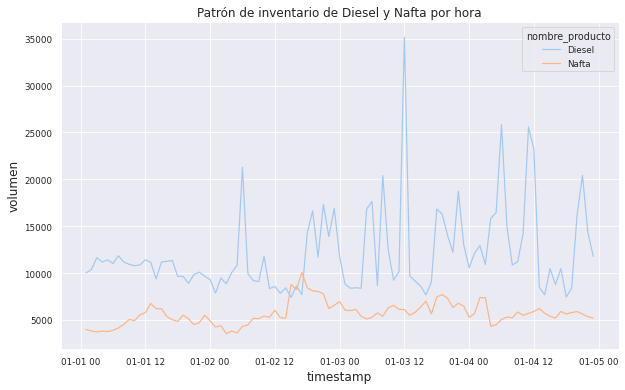

In [ ]:
df_pro_resa=df_pro_resa[(df_pro_resa["timestamp"]>"2021-01-01") & ((df_pro_resa["timestamp"]<"2021-01-05"))]
plt.figure(figsize=(10,6))
plt.title("Patrón de inventario de Diesel y Nafta por hora")
seaborn.lineplot(data=df_pro_resa[(df_pro_resa.nombre_producto== "Diesel") | (df_pro_resa.nombre_producto == "Nafta")], x="timestamp", y="volumen", hue="nombre_producto")

Análisis por día.

In [ ]:
df_pro_resa=df.groupby("nombre_producto").resample("D", on="timestamp").mean().reset_index()

In [ ]:
df_pro_resa=df_pro_resa[(df_pro_resa["timestamp"]>"2021-01-01") & ((df_pro_resa["timestamp"]<"2021-01-10"))]

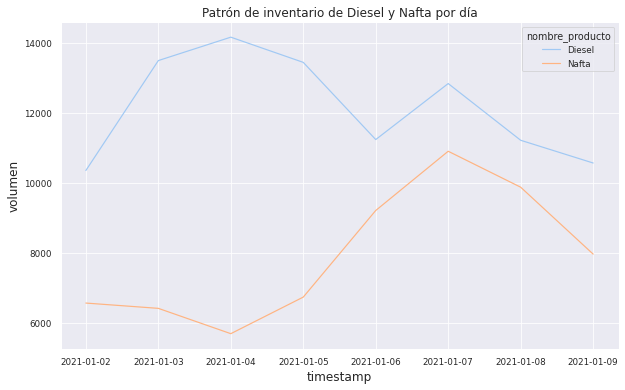

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Patrón de inventario de Diesel y Nafta por día")
seaborn.lineplot(data=df_pro_resa[(df_pro_resa.nombre_producto== "Diesel") | (df_pro_resa.nombre_producto == "Nafta")], x="timestamp", y="volumen", hue="nombre_producto")

Análisis por mes

In [ ]:
df_pro_resa=df.groupby("nombre_producto").resample("M", on="timestamp").mean().reset_index()

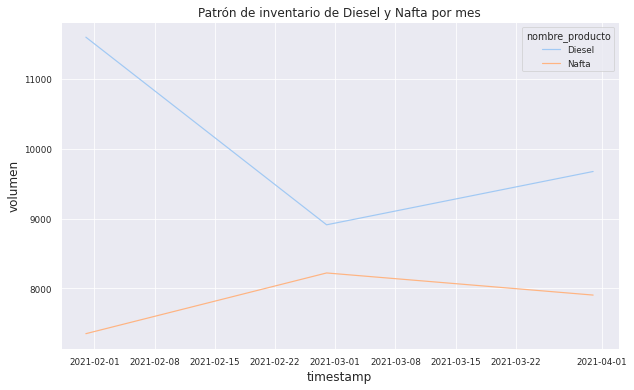

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Patrón de inventario de Diesel y Nafta por mes")
seaborn.lineplot(data=df_pro_resa[(df_pro_resa.nombre_producto== "Diesel") | (df_pro_resa.nombre_producto == "Nafta")], x="timestamp", y="volumen", hue="nombre_producto")

Estos gráficos muestran una variación en el tiempo de los inventarios de nafta y diesel, siguiendo en varias ocasiones patrones inversos. Por otra parte, se puede observar que las variaciones temporales, en general, son más pronunciadas para el caso del Diesel.

### Primera y segunda derivada del `volumen` en el tiempo

La primer derivada nos da información de los movimientos del `volumen` en el tiempo. Si el líquido sube, la pendiente es positiva, si es negativa, el líquido baja. Valores cercanos a cero nos indican poco movimiento, mientras que valores más grandes nos indican que el líquido se mueve en grandes cantidades.

In [ ]:
# Cálculo de diferencia entre valores para obtener la pendiente
df['volumen_diff'] = df.groupby('id_tanque')['volumen'].diff()

In [ ]:
# Seleccionamos un tanque en un rango de tiempo
id_tanque = '500'

sample_tanque = df.query("""
    id_tanque == @id_tanque \
    and timestamp > '2021-01-05 09:00' \
    and timestamp < '2021-01-06 12:00'
""")
sample_tanque[['id_tanque', 'volumen', 'volumen_diff']].tail()

,id_tanque,volumen,volumen_diff
timestamp,,,
2021-01-06 11:54:29,500,32341.00,0.00
2021-01-06 11:55:28,500,32275.70,-65.30
2021-01-06 11:56:26,500,32232.09,-43.61
2021-01-06 11:57:25,500,32232.09,0.00
2021-01-06 11:58:24,500,32232.09,0.00


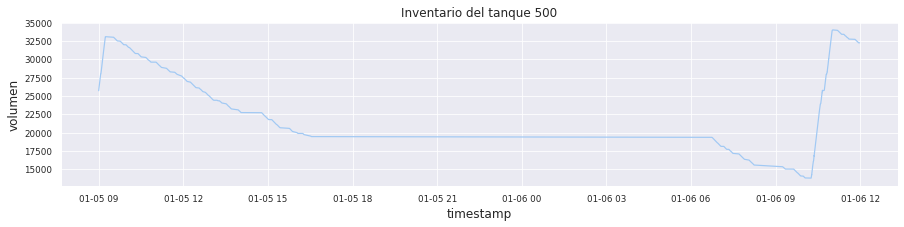

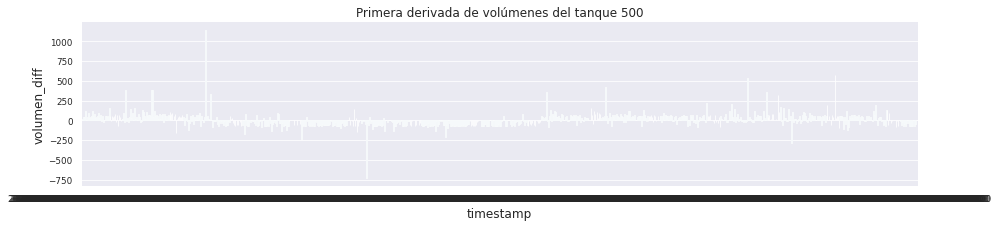

In [ ]:
# Graficamos
fig = plt.figure(figsize=(15, 3))
seaborn.lineplot(
    y=sample_tanque['volumen'], 
    x=sample_tanque['timestamp']
)
plt.title(f"Inventario del tanque {id_tanque}")

fig = plt.figure(figsize=(15, 3))
seaborn.barplot(
    y=sample_tanque['volumen_diff'], 
    x=sample_tanque['timestamp'],
    color="lightblue"
)
plt.title(f"Primera derivada de volúmenes del tanque {id_tanque}")
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

La segunda derivada nos puede indicar cuál es la aceleración del movimiento del tanque.

In [ ]:
# Cálculo de diferencia entre diferencias para obtener la aceleración
df['volumen_second_diff'] = df.groupby('id_tanque')['volumen_diff'].diff()

In [ ]:
# Seleccionamos un tanque en un rango de tiempo
sample_tanque[['id_tanque', 'volumen', 'volumen_diff', 'volumen_second_diff']].tail()

,id_tanque,volumen,volumen_diff,volumen_second_diff
timestamp,,,,
2021-02-01 11:54:24,500,18801.20,-65.60,-0.00
2021-02-01 11:55:23,500,18735.60,-65.60,0.00
2021-02-01 11:56:22,500,18670.00,-65.60,0.00
2021-02-01 11:57:20,500,18604.40,-9.33,-24.79
2021-02-01 11:58:19,500,18590.05,-59.07,19.31


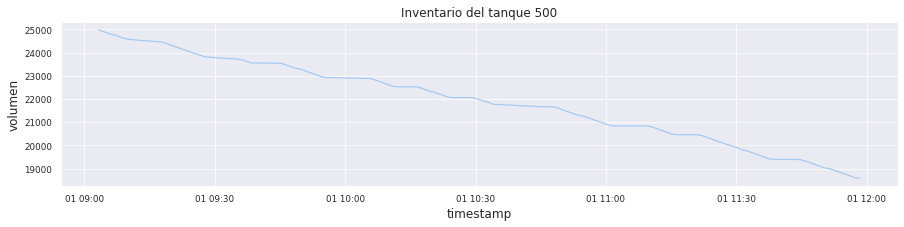

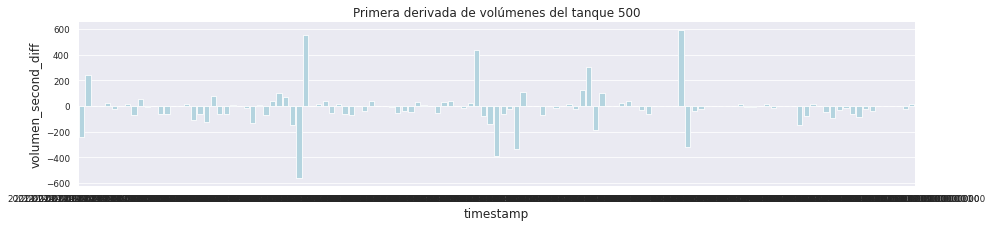

In [ ]:
# Graficamos
fig = plt.figure(figsize=(15, 3))
seaborn.lineplot(
    y=sample_tanque['volumen'], 
    x=sample_tanque['timestamp']
)
plt.title(f"Inventario del tanque {id_tanque}")

fig = plt.figure(figsize=(15, 3))
seaborn.barplot(
    y=sample_tanque['volumen_second_diff'], 
    x=sample_tanque['timestamp'],
    color="lightblue"
)
plt.title(f"Primera derivada de volúmenes del tanque {id_tanque}")
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

### Patrones de consumos por unidad de tiempo por centro operativo

Para poder calcular los consumos, debemos sumar todas las diferencias negativas (primera derivada) por tanque de acuerdo a distintos rangos de tiempo. 

Seleccionamos los rangos de tiempo por hora, diario y mensual para calcular el consumo.

In [ ]:
df['period_hour'] = df['timestamp'].dt.to_period('H')
df['period_day'] = df['timestamp'].dt.to_period('D')
df['period_month'] = df['timestamp'].dt.to_period('M')

Sumamos la columna calculada `volumen_diff` agrupando por tanque y por periodo.

In [ ]:
# Nos quedamos con los valores negativos para facilitar la suma
df['neg_volumen_diff'] = numpy.where(
    df['volumen_diff'] < 0, 
    df['volumen_diff'].abs(), 
    0
)

In [ ]:
# Calculamos la suma por periodo y lo agregamos a una nueva columna
df['consumos_hourly'] = df\
    .groupby(['id_tanque', 'period_hour'])['neg_volumen_diff']\
    .transform('sum')
df['consumos_daily'] = df\
    .groupby(['id_tanque', 'period_day'])['neg_volumen_diff']\
    .transform('sum')
df['consumos_monthly'] = df\
    .groupby(['id_tanque', 'period_month'])['neg_volumen_diff']\
    .transform('sum')

Graficamos los consumos de un tanque de muestra.  

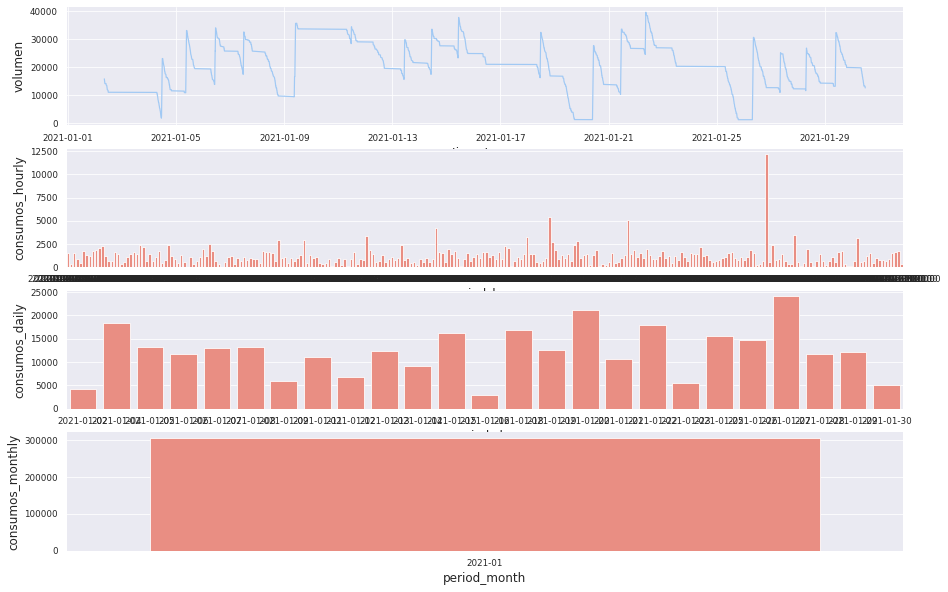

In [ ]:
id_tanque = '500'

sample_tanque = df.query("""
    id_tanque == @id_tanque \
    and timestamp > '2021-01-01' \
    and timestamp < '2021-02-01'
""")

fig, axes = plt.subplots(4, 1, sharex=False, figsize=(15, 10))
seaborn.lineplot(
    y=sample_tanque['volumen'], 
    x=sample_tanque['timestamp'],
    ax=axes[0]
)
seaborn.barplot(
    y=sample_tanque['consumos_hourly'], 
    x=sample_tanque['period_hour'],
    ax=axes[1],
    color="salmon"
)
seaborn.barplot(
    y=sample_tanque['consumos_daily'], 
    x=sample_tanque['period_day'],
    ax=axes[2],
    color="salmon"
)
seaborn.barplot(
    y=sample_tanque['consumos_monthly'], 
    x=sample_tanque['period_month'],
    ax=axes[3],
    color="salmon"
)
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

A veces puede haber ruido en el volumen histórico de los tanques que pueden confundirse con movimientos de combustible, por lo tanto, no sería correcto utilizar las diferencias entre volúmenes en el tiempo sin ningún tratamiento previo. Necesitamos suavizar los registros para obtener las diferencias reales. Para obtener el cálculo de consumos más preciso se utilizan las **direfencias entre las medias móviles**, tratamiento que será cubierto más adelante en el práctico de curación. 

Una vez obtenido el consumo en distintos periodos de tiempo por tanque, agrupamos los tanques para obtener los consumos por centro operativo.

In [ ]:
# Calculamos la suma por periodo y lo agregamos a una nueva columna
df['consumos_centro_hourly'] = df\
    .groupby(['id_equipo', 'period_hour'])['consumos_hourly']\
    .transform('sum')
df['consumos_centro_daily'] = df\
    .groupby(['id_equipo', 'period_day'])['consumos_daily']\
    .transform('sum')
df['consumos_centro_monthly'] = df\
    .groupby(['id_equipo', 'period_month'])['consumos_monthly']\
    .transform('sum')

Graficamos los consumos de un centro operativo de muestra.

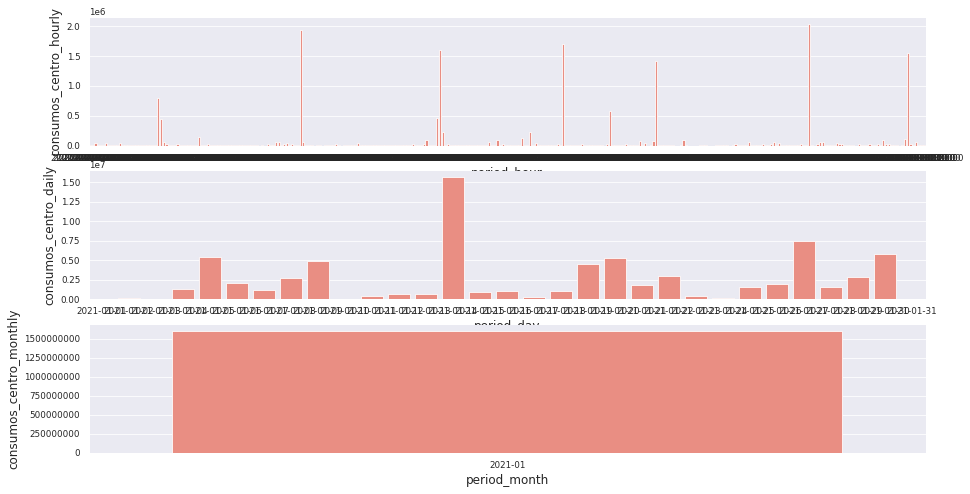

In [ ]:
id_equipo = '430'

sample_equipo = df.query("""
    id_equipo == @id_equipo \
    and timestamp > '2021-01-01' \
    and timestamp < '2021-02-01'
""")

fig, axes = plt.subplots(3, 1, sharex=False, figsize=(15, 8))
seaborn.barplot(
    y=sample_equipo['consumos_centro_hourly'], 
    x=sample_equipo['period_hour'],
    ax=axes[0],
    color="salmon"
)
seaborn.barplot(
    y=sample_equipo['consumos_centro_daily'], 
    x=sample_equipo['period_day'],
    ax=axes[1],
    color="salmon"
)
seaborn.barplot(
    y=sample_equipo['consumos_centro_monthly'], 
    x=sample_equipo['period_month'],
    ax=axes[2],
    color="salmon"
)
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

### Patrones de consumo por unidad de tiempo por industria

In [ ]:
# Calculamos la suma por periodo y lo agregamos a una nueva columna
df['consumos_industria_hourly'] = df\
    .groupby(['industria', 'period_hour'])['consumos_hourly']\
    .transform('sum')
df['consumos_industria_daily'] = df\
    .groupby(['industria', 'period_day'])['consumos_daily']\
    .transform('sum')
df['consumos_industria_monthly'] = df\
    .groupby(['industria', 'period_month'])['consumos_monthly']\
    .transform('sum')

In [ ]:
df.groupby(['industria'])['consumos_industria_hourly'].mean().sort_values()

industria
Telcos              78506.38
Otras              452866.53
Mining             587765.19
Oil&Gas           1279760.88
Service Station   1708982.50
Construction      2524114.75
Industry          2900375.25
Agriculture       7978278.00
Transportation    9172227.00
Name: consumos_industria_hourly, dtype: float32

In [ ]:
df.groupby(['industria'])['consumos_industria_daily'].mean().sort_values()

industria
Otras                 849787.88
Mining               7298778.00
Telcos              27625744.00
Oil&Gas             97102560.00
Industry           100771680.00
Agriculture        287343104.00
Service Station    390145952.00
Construction       437399360.00
Transportation    1030982848.00
Name: consumos_industria_daily, dtype: float32

In [ ]:
df.groupby(['industria'])['consumos_industria_monthly'].mean().sort_values()

industria
Otras                 14010265.00
Mining              3666168576.00
Telcos             19750848512.00
Industry           20125767680.00
Oil&Gas            54254645248.00
Agriculture        67603415040.00
Construction      191348195328.00
Service Station   272947232768.00
Transportation    678744489984.00
Name: consumos_industria_monthly, dtype: float32

### Patrones de consumo por unidad de tiempo por producto

In [ ]:
df['consumos_producto_hourly'] = df\
    .groupby(['nombre_producto', 'period_hour'])['consumos_hourly']\
    .transform('sum')
df['consumos_producto_daily'] = df\
    .groupby(['nombre_producto', 'period_day'])['consumos_daily']\
    .transform('sum')
df['consumos_producto_monthly'] = df\
    .groupby(['nombre_producto', 'period_month'])['consumos_monthly']\
    .transform('sum')

In [ ]:
df.groupby(['nombre_producto'])['consumos_producto_hourly'].mean().sort_values()

nombre_producto
Glifosato                        12.80
Euro-Diesel                     274.40
Euro 5                          319.53
Gasoil Grado 3 800059           833.25
Ultra-Diesel                   1589.76
Premium                        2356.24
V-Power Nitro                 12815.45
Nafta V-Power                 12826.23
Aceite                        22505.74
VP Nafta                      49138.38
V-Power Diesel                49791.39
VP Diesel                     56567.20
Quantum Nafta                 57898.19
Infinia Nafta                 61761.69
VP-Diesel                     64743.46
B100                          66801.31
VP-Nafta                      74256.28
Producto 1                    74901.48
Urea                          87416.51
V-Power Nafta                104494.50
Infinia                      105091.49
Infinia Diesel               114446.52
BIO                          116438.38
DIESEL EURO                  128063.07
Kerosene                     141812.86
Gas Oil E

In [ ]:
df.groupby(['nombre_producto'])['consumos_producto_daily'].mean().sort_values()

nombre_producto
Glifosato                           20.00
Euro-Diesel                        509.47
Euro 5                             568.55
Gasoil Grado 3 800059             2296.60
Ultra-Diesel                      4124.57
Premium                          10107.61
Quantum Nafta                    61583.09
Aceite                           80848.11
B100                            158953.02
V-Power Nitro                   171886.62
Nafta V-Power                   315051.69
Urea                            318495.69
EURO                            318587.91
S1002050010                     350412.16
Kerosene                        372627.84
Infinia                         488348.84
BIO                             658750.25
Infinia Diésel                  880976.12
Gasoil grado 2                  890742.06
Ultra Diesel                   1080946.12
Gas Oil Grado 3                1134106.12
Gas Oil Grado 2                1303728.50
Gas Oil Comun Gr 2             1566117.75
V-Power Diesel    

In [ ]:
df.groupby(['nombre_producto'])['consumos_producto_monthly'].mean().sort_values()

nombre_producto
Glifosato                             20.00
Gasoil Grado 3 800059              23665.87
Euro 5                             48515.29
Euro-Diesel                        72514.23
Ultra-Diesel                      390606.59
Premium                           966069.06
Quantum Nafta                    3405302.75
COMBUSTIBLE -  DIESEL 500        3542676.75
Gas Oil Comun Gr 2               3653742.25
S1002050010                      4246096.50
Urea                             4874547.00
Infinia                          5062928.50
Aceite                           6622089.00
B100                             7877690.50
Euro 3                           8483968.00
Gasoil Grado 2 800060            8845191.00
Ultra Diesel                    10222439.00
Producto 2                      11415672.00
Infinia Diésel                  12305867.00
Kerosene                        12835017.00
Ultra Diesel                    14306718.00
GAS OIL                         17998820.00
EURO            

### Análisis estadístico de los inventarios y consumos por industria


Se comparará el patrón de inventario y consumo de combustibles de la industria minera y de telecomunicaciones a través del test de hipótesis. Planteamos, por un lado, la hipótesis nula (H0) de que las medias de volumen y consumo son iguales y, por otro lado, la hipótesis alternativa (H1) de que las medias son diferentes. 

In [ ]:
import scipy.stats

In [ ]:
Mineria=df[df.industria == "Mining"].volumen
Telcos= df[df.industria == "Telcos"].volumen

In [ ]:
Mineria.mean(),  Mineria.var(), Mineria.std(), Mineria.count()

(24533.58984375, 123766648.0, 11125.0458984375, 49379)

In [ ]:
Telcos.mean(),  Telcos.var(), Telcos.std(), Telcos.count()

(224.62779235839844, 79062.2109375, 281.1800231933594, 311756)

Debido a que las variazas y el tamaño muestral de ambos grupos es distinto, se llevó a cabo el test t de Welch que asume varianzas y tamaños muestrales diferentes.

In [ ]:
scipy.stats.ttest_ind(Mineria, Telcos, equal_var = False)

Ttest_indResult(statistic=485.5232508512948, pvalue=0.0)

Los resultados arrojaron diferencias significativas ($p= 0$) en el inventario de combustibles de las industrias minera y de telecomunicaciones, es decir, se rechaza la hipótesis nula de igualdad de medias. Asimismo, la media del volumen de combustible de la industria minera es mayor a la de telecomunicaciones.

In [ ]:
Mineria_consumo=df[df.industria == "Mining"].consumos_daily
Telcos_consumo= df[df.industria == "Telcos"].consumos_daily

In [ ]:
Mineria_consumo.mean(),  Mineria_consumo.var(), Mineria_consumo.std(), Mineria_consumo.count()

(9616.9365234375, 22744478.0, 4769.1171875, 49379)

In [ ]:
Telcos_consumo.mean(),  Telcos_consumo.var(), Telcos_consumo.std(), Telcos_consumo.count()

(7060.5732421875, 16082786.0, 4010.3349609375, 311756)

Debido a que las variazas y el tamaño muestral de ambos grupos es ditinto, se llevó a cabo el test t de Welch que asume varianzas y tamaños muestrales diferentes.

In [ ]:
scipy.stats.ttest_ind(Mineria_consumo, Telcos_consumo, equal_var = False)

Ttest_indResult(statistic=113.08228729931358, pvalue=0.0)

Los resultados mostraron diferencias significativas ($p= 0$) en el consumo diario de combustibles por parte de las industrias minera y de telecomunicaciones, es decir, se rechaza la hipótesis nula de igualdad de medias. La industria minera consume más combustible por día en relación a la industria de telecomunicaciones.

### Análisis estadístico de inventarios y consumos por producto

Se comparará el patrón de inventario y consumo de los combustibles diesel y nafta mediante la aplicación del test de hipótesis, al igual que en el caso anterior. Planteamos, por un lado, la hipótesis nula (H0) de que las medias de volumen y consumo son iguales y, por otro lado, la hipótesis alternativa (H1) de que las medias son diferentes. 

In [ ]:
Diesel=df[df.nombre_producto == "Diesel"].volumen
Nafta= df[df.nombre_producto == "Nafta"].volumen

In [ ]:
Diesel.mean(), Diesel.var(), Diesel.std(), Diesel.count()

(9960.8427734375, 174393472.0, 13205.8125, 2834112)

In [ ]:
Nafta.mean(), Nafta.var(), Nafta.std(), Nafta.count()

(7816.791015625, 16386733.0, 4048.052978515625, 762267)

Debido a que las variazas y el número de observaciones de ambos grupos es ditinto, se llevó a cabo el test t de Welch que asume varianzas y tamaños muestrales diferentes.

In [ ]:
scipy.stats.ttest_ind(Diesel, Nafta, equal_var = False)

Ttest_indResult(statistic=230.22211390341948, pvalue=0.0)

Los resultados mostraron diferencias significativas ($p=0$) en el inventario (volumen) de los combustibles diesel y nafta, de esta manera, se rechaza la hipótesis nula de igualdad de medias. Asimismo, el inventario de diesel fue mayor al de nafta.

In [ ]:
Diesel_consumo=df[df.nombre_producto == "Diesel"].consumos_daily
Nafta_consumo= df[df.nombre_producto == "Nafta"].consumos_daily

In [ ]:
Diesel_consumo.mean(), Diesel_consumo.var(), Diesel_consumo.std(), Diesel_consumo.count()

(39387.59765625, 6929056768.0, 83240.953125, 2834112)

In [ ]:
Nafta_consumo.mean(), Nafta_consumo.var(), Nafta_consumo.std(), Nafta_consumo.count()

(9196.287109375, 25913560.0, 5090.5361328125, 762267)

Debido a que las variazas y el número de observaciones de ambos grupos es ditinto, se llevó a cabo el test t de Welch que asume varianzas y tamaños muestrales diferentes.

In [ ]:
scipy.stats.ttest_ind(Diesel_consumo, Nafta_consumo, equal_var = False)

Ttest_indResult(statistic=605.2955659825718, pvalue=0.0)

Los resultados mostraron diferencias significativas ($p=0$) en el consumo diario de los combustibles diesel y nafta, siendo mayor el de diesel. De esta manera, se rechaza la hipótesis nula de igualdad de medias.

### Media móvil de inventarios para cada indsutria

La **media móvil** sobre el `volumen` nos muestra el inventario de forma suavizada. Para realizar el cálculo de la media móvil, se elige una ventana de tiempo.

Se selecciona un centro operativo por industria para realizar el análisis.

In [ ]:
df['moving_avg'] = df.groupby('id_tanque')['volumen'].transform(
    lambda x: x.rolling(window='2T', min_periods=2).mean()
)

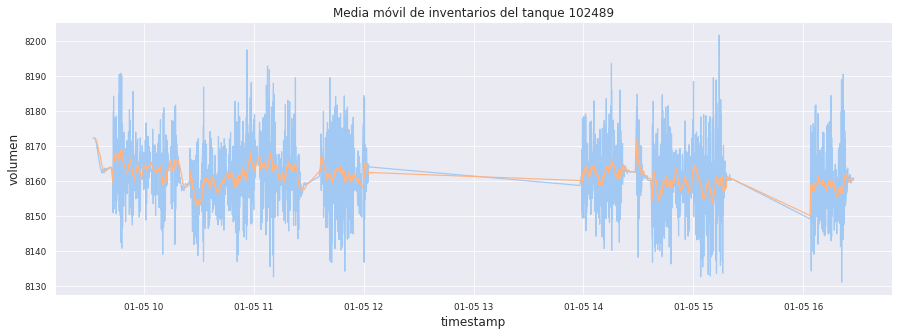

In [ ]:
id_tanque = '102489'
sample = df.query("""
    id_tanque == @id_tanque \
    and timestamp > '2021-01-05' \
    and timestamp < '2021-01-06'
""")

fig = plt.figure(figsize=(15, 5))
seaborn.lineplot(
    data=sample, y='volumen', x='timestamp'
)
seaborn.lineplot(
    data=sample, y='moving_avg', x='timestamp'
)

plt.title(f"Media móvil de inventarios del tanque {id_tanque}")
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

## Primeras predicciones

¿Cómo podemos realizar un cálculo simple para estimar inventarios en el corto plazo?

Sugerimos a continuación algunas ideas Naïve. 

In [ ]:
id_tanque = '1014'
sample = df.query("""
    id_tanque == @id_tanque \
    and timestamp > '2021-01-01' \
    and timestamp < '2021-01-02'
""")

### Repetición del último valor visto en el tiempo.

Para esta predicción utilizaremos el último valor visto y lo repetimos en el tiempo.

In [ ]:
# Creamos los índices de tiempo siguientes a partir del último valor
indexes = pd.date_range(sample.iloc[-1]['timestamp'], freq='5T', periods=10)

# Replicamos el último valor
data = [sample.iloc[-1]['volumen']] * 10

# Creamos nuestro nuevo dataset
sample_pred = pd.DataFrame({ 'timestamp': indexes, 'volumen': data })
sample_pred.set_index('timestamp', inplace=True)

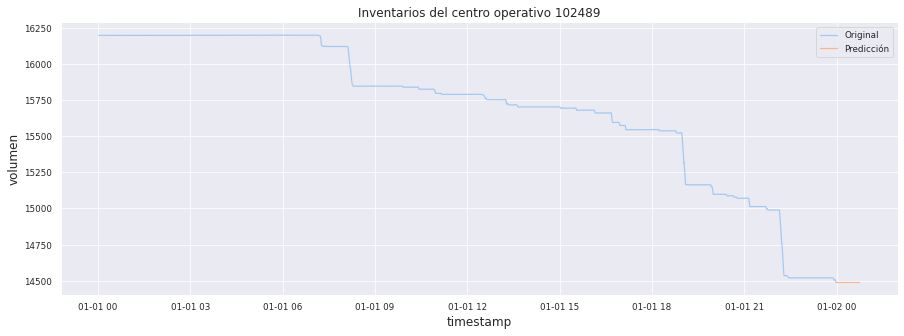

In [ ]:
fig = plt.figure(figsize=(15, 5))
seaborn.lineplot(
    data=sample, y='volumen', x='timestamp', label='Original'
)
seaborn.lineplot(
    data=sample_pred, y='volumen', x='timestamp', label='Predicción'
)

plt.title(f"Inventarios del centro operativo {id_equipo}")
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

### Media móvil de últimos valores vistos

In [ ]:
# Creamos los índices de tiempo siguientes a partir del último valor
indexes = pd.date_range(sample.iloc[-1]['timestamp'], freq='5T', periods=10)

# Replicamos el último valor
data = [sample.iloc[-1]['moving_avg']] * 10

# Creamos nuestro nuevo dataset
sample_pred = pd.DataFrame({ 'timestamp': indexes, 'volumen': data })
sample_pred.set_index('timestamp', inplace=True)

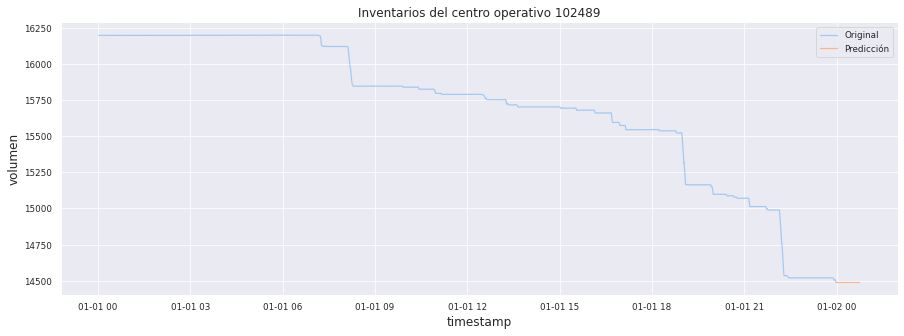

In [ ]:
fig = plt.figure(figsize=(15, 5))
seaborn.lineplot(
    data=sample, y='volumen', x='timestamp', label='Original'
)
seaborn.lineplot(
    data=sample_pred, y='volumen', x='timestamp', label='Predicción'
)

plt.title(f"Inventarios del centro operativo {id_equipo}")
plt.ticklabel_format(style='plain', axis='y')
seaborn.despine()

Otra predicción puede ser que al último valor, se le acumule la última diferencia para obtener una simulación del último movimiento.

## Conclusiones
A partir de la exploración de los datos de nuestro dataset, pudimos detectar la presencia de numerosos valores atípicos y erróneos de nuestra variable de interés `volumen` de combustible. Por un lado, estos valores atípicos fueron filtramos y, por otro lado, eliminamos a través del método del rango intercuatílico de la mediana móvil. Sin embargo, no observamos un cambio importante en la distribución de la variable, que se mantiene sesgada hacia izquierda con una cola importante hacia la derecha (asimetría derecha). Esto nos podría indicar que todavía existen valores atípicos o erróneos y faltantes a eliminar o imputar en nuestro dataset. En este sentido, también se detectó la presencia de tanques de combustible con gaps temporales que podrían ser imputados en una siguiente instancia. Por otro lado, pudimos detectar la presencia de variables correlacionadas, las cuales fueron desechadas del dataframe, como por ejemplo el nivel de combustible que se correlacionó fuertemente con la variable volumen. Además, observamos que las features `industria`y `nombre_producto`poseen categorías con pocas observaciones por lo que se procedió a unir categoría poco frecuentes o a tomar aquellas con mayor cantidad de observaciones, respectivamente. Sin embargo, estas categorías deberían ser revisadas en mayor detalle en el próximo práctico de curación. Cuando se analizaron los patrones de inventario y consumo por industria y combustible se observaron interesantes diferencias y variaciones temporales. Las industrias Oil&Gas y minera presentaron los mayores inventarios de combustibles, mientras que en el caso del tipo de combustibles, el Diesel fue el producto con mayor inventario con respecto a la Nafta, a pesar de que el gráfico muestra el patrón inverso. Esto se debe a la diferencia en el tamaño muestral de ambos combustibles, el cual es menor en el caso de la nafta influyendo sobre la estimación del inventario. Por su parte, el consumo también varió entre industrias y productos. Particularmente, el consumo diario de combustible por parte de la industria minera fue mayor en relación a la de telecomunicaciones, mientras que el consumo de Disel fue significativamente mayor comparado con el de Nafta. Sin embargo, estas estimaciones son solo aproximaciones ya que nuestros datos necesitan de un proceso de curación más profundo que se abordará en el siguiente práctico de curación. 